# CAPSTONE PROJECT: MARKET REGIMES IN QWIM

Team member: Hanlu Ni, Yipei Zhang, Xilu Luo

# Step 1 Create the DataFrame

In [7]:
import pandas as pd
import os
import warnings
import datetime
# Hides deprecation warnings for sklearn
warnings.filterwarnings("ignore")

os.chdir("C:/Users/Hanlu Ni/Desktop/my documents/Spring2021/capstone/码/raw data")

In [13]:
data_total = {}
name_list = []

for name in os.listdir():
    data = pd.read_excel(name)
    print(name)
    for i in range(len(data)):
        if data.iloc[i,0] == "Date":
            st_name = name.split(".")[0]
            #print(st_name)
            output = data.iloc[i+1:,:]
            output.columns = data.iloc[i,:]
            output.rename(columns = {"PX_LAST":st_name}, inplace = True)
            output = output.iloc[:,:2]
            output.Date = output.Date.apply(lambda x :datetime.datetime.strftime(x,"%Y-%m-%d"))
            output = output.reset_index(drop = True)
            output.index.name = None
            name_list.append(st_name)
            data_total.update({st_name:output})
            break
        

AMZN US Equity.xlsx
BEN US Equity.xlsx
C01 Comdty.xlsx
CL1 Comdty.xlsx
GOLDS Comdty.xlsx
JPM US Equity.xlsx
SPGSCI Index.xlsx
S_P500 Index.xlsx


In [14]:
df = data_total[name_list[0]]

for i,name in enumerate(name_list):
    if i == 0:
        continue
    df = pd.merge(df,data_total[name], on = 'Date', how = 'inner')
    
    
df = df.sort_values(by = "Date", ascending = True)
df = df.reset_index(drop = True)

df = df.set_index("Date")
#df

In [283]:
df.iloc[-504:]

5,AMZN US Equity,BEN US Equity,C01 Comdty,CL1 Comdty,GOLDS Comdty,JPM US Equity,SPGSCI Index,S_P500 Index
Date,,,,,,,,
2019-06-04,1729.56,33,5578,53.48,1325.52,109.74,406.956,2803.27
2019-06-06,1754.36,33.17,5500,52.59,1335.33,110.37,402.926,2843.49
2019-06-07,1804.03,33.64,5490,53.99,1340.86,109.16,407.168,2873.34
2019-06-10,1860.63,33.4,5380,53.26,1327.98,110.34,405.665,2886.73
2019-06-11,1863.7,33.37,5372,53.27,1326.84,110.68,407.347,2885.72
...,...,...,...,...,...,...,...,...
2021-06-28,3443.89,32.54,5080,72.91,1778.48,154.33,528.864,4290.61
2021-06-29,3448.14,31.92,5106,72.98,1761.24,154.14,530.029,4291.8
2021-06-30,3440.16,31.99,5104,73.47,1770.11,155.54,535.976,4297.5


In [ ]:
#df.to_csv("data_total.csv")

# Step 2 Define a function BenchmarkRegime

Step 2.1: assume rebalance monthly(21 days)
    #change dataframe into monthly basis
     define a function Modified_Dataframe(ndays,df): 
        ndays: (ex.5 if rebalance weekly, 21 if rebalance monthly)
        df: the dataframe we want to modify
        return the n-by-3 modified dataframe either on a weekly basis or a monthly basis, columns = Date, ndays return, 
            ndays volatility (note：index is number)

In [207]:
import numpy as np

def Modified_Dataframe(ndays,df):
    modified_df = pd.DataFrame(columns = ["Date", "ndays return", "ndays volatility"])
    # find the percentage log return instead of daily_return = df.pct_change(1)[1:]
    
    daily_return = df.pct_change(1).apply(lambda x: np.log(1+x))[1:]
    for i in range(0,len(daily_return)):
        if i % ndays == ndays-1:
            temp_date = daily_return.index[i]
            temp_ndays_return = daily_return[:i+1][-ndays:].mean()*ndays
            temp_ndays_volatility = daily_return[:i+1][-ndays:].std()*np.sqrt(ndays)
            modified_df.loc[len(modified_df.index)] = [temp_date, temp_ndays_return,temp_ndays_volatility]
    
    #modified_df.set_index("Date")
    return modified_df
    
    

In [ ]:
#Modified_Dataframe(5,df["S_P500 Index"]).set_index("Date")

Step 2.2 find the optimal number of state using BIC
    #define a function bic_hmmlearn(X)
        X: train_df get from modified_Dataframe function
        return the optimal number of states we should use

In [208]:
# pip install --upgrade --user hmmlearn
from hmmlearn.hmm import GaussianHMM
import numpy as np

def bic_general(likelihood_fn, k, X):
    """likelihood_fn: Function. Should take as input X and give out   the log likelihood
                  of the data under the fitted model.
           k - int. Number of parameters in the model. The parameter that we are trying to optimize.
                    For HMM it is number of states.
                    For GMM the number of components.
           X - array. Data that been fitted upon.
    """
    bic = np.log(len(X))*k - 2*likelihood_fn(X)
    return bic

def bic_hmmlearn(X):
    lowest_bic = np.infty
    bic = []
    n_states_range = range(2,6)
    for n_components in n_states_range:
        hmm_curr = GaussianHMM(n_components=n_components, covariance_type='diag')
        hmm_curr.fit(X)

        # Calculate number of free parameters
        # free_parameters = for_means + for_covars + for_transmat + for_startprob
        # for_means & for_covars = n_features*n_components
        n_features = hmm_curr.n_features
        free_parameters = n_components*n_features + n_components*n_features*n_features + n_components*n_components

        bic_curr = bic_general(hmm_curr.score, free_parameters, X)
        bic.append(bic_curr)
        if bic_curr < lowest_bic:
            lowest_bic = bic_curr
            optimal_state = n_components
    #print(bic)
    return optimal_state

In [ ]:
#train_df = Modified_Dataframe(5,df["S_P500 Index"]).set_index("Date")[:"2019-07-02"]
#bic_hmmlearn(train_df)

Step 2.3:use gaussian hmm get benchmark regime
    # define a function BenchmarkRegime(enddate, benchmark_index,optimal_state,ndays)
    input: 
        enddate: the date our regime analysis will end (ex. "2019-07-02")
        benchmark_index: ex. "S_P500 Index", "SPGSCI Index")
        ndays: (ex.5 if rebalance weekly, 21 if rebalance monthly)
    output:
        date array: we want to predict the state a week after "2019-07-02", so this function will return an array of date that 
            have the same state with the state a week after "2019-07-02"

In [270]:
# pip install --upgrade --user hmmlearn
from hmmlearn.hmm import GaussianHMM
def BenchmarkRegime(enddate, benchmark_index, ndays):
    train_df = Modified_Dataframe(ndays,df[benchmark_index]).set_index("Date")[:enddate]
    test_df = Modified_Dataframe(ndays,df[benchmark_index]).set_index("Date")[enddate:]
    optimal_state = bic_hmmlearn(train_df)
    model = GaussianHMM(n_components = optimal_state)
    
    print(optimal_state)
    
    model.fit(train_df)
    predictions = model.predict(train_df)
    next_week_prediction = model.predict(test_df)[0]
    Date_regime = []
    for i in train_df.reset_index().index:
        if predictions[i] == next_week_prediction:
            Date_regime.append(train_df.reset_index().loc[i][0])
    return Date_regime
    

In [ ]:
#BenchmarkRegime("2021-06-08","S_P500 Index",5)

# Step 3 Find benchmark regime for each date
Define a function Portfolio_Benchmark_regime(startdate,ndays,benchmark_index1, benchmark_index2)
    #input:
        startdate
        ndays
        benchmark_index1
        benchmark_index2
    #output:
        portfolio_benchmark_regime: n*2 dataframe, with coloumns = {"Date", "regimedate"}

assumptions: 
    #optimal state = 2 for all benchmark.
    #monthly rebalance(21 days)
    #portfolio start on "2019-06-14"

In [273]:
def Portfolio_Benchmark_regime(startdate, ndays, benchmark_index1, benchmark_index2):
    
    all_date = Modified_Dataframe(ndays,df[benchmark_index1]).set_index("Date").index
    portfolio_date = Modified_Dataframe(ndays,df[benchmark_index1]).set_index("Date")[all_date>=startdate].index
    benchmark_date_df = pd.DataFrame(columns = ["Date", "Regime Date"])
    for i in portfolio_date:
        print(i)
        print("regime1")
        regime1 = BenchmarkRegime(i,benchmark_index1,ndays)
        print("regime2")
        regime2 = BenchmarkRegime(i,benchmark_index2,ndays)
        regime = np.intersect1d(regime1, regime2)
        # if the predicted combination of regime does not exist before, simply use all the dates before for strategy analysis
        if len(regime) == 0:
            regime = all_date[all_date<=i]
        #print(i)
        benchmark_date_df.loc[len(benchmark_date_df.index)] = [i,regime]
    return benchmark_date_df

In [211]:
def Portfolio_Benchmark_regime_withoutregime(startdate, ndays, benchmark_index1, benchmark_index2):
    
    all_date = Modified_Dataframe(ndays,df[benchmark_index1]).set_index("Date").index
    portfolio_date = Modified_Dataframe(ndays,df[benchmark_index1]).set_index("Date")[all_date>=startdate].index
    benchmark_date_df = pd.DataFrame(columns = ["Date", "Regime Date"])
    for i in portfolio_date:
        regime = all_date[all_date<=i]
        print(i)
        benchmark_date_df.loc[len(benchmark_date_df.index)] = [i,regime]
    return benchmark_date_df

In [260]:
#monthly_2year_regime= Portfolio_Benchmark_regime("2019-06-14",21,"S_P500 Index","SPGSCI Index")
#monthly_2year_regime.to_csv("monthly_2year_regime.csv")

In [274]:
# want to see the optimal number of state for benchmark index
# monthly 2 year
# regime 1 is S_P500 Index
# regime 2 is SPGSCI Index
Portfolio_Benchmark_regime("2019-06-14",21,"S_P500 Index","SPGSCI Index")


2019-06-14
regime1
2
regime2
2
2019-07-16
regime1
2
regime2
2
2019-08-16
regime1
2
regime2
2
2019-09-18
regime1
2
regime2
2
2019-10-22
regime1
2
regime2
2
2019-11-22
regime1
2
regime2
2
2019-12-24
regime1
2
regime2
2
2020-01-27
regime1
2
regime2
2
2020-02-26
regime1
2
regime2
2
2020-03-27
regime1
3
regime2
2
2020-05-05
regime1
3
regime2
2
2020-06-04
regime1
3
regime2
2
2020-07-06
regime1
3
regime2
2
2020-08-04
regime1
3
regime2
2
2020-09-02
regime1
3
regime2
2
2020-10-05
regime1
3
regime2
2
2020-11-04
regime1
3
regime2
2
2020-12-08
regime1
3
regime2
2
2021-01-08
regime1
3
regime2
2
2021-02-10
regime1
3
regime2
2
2021-03-15
regime1
3
regime2
2
2021-04-15
regime1
3
regime2
2
2021-05-14
regime1
3
regime2
2
2021-06-15
regime1
3
regime2
2


,Date,Regime Date
0,2019-06-14,"[2004-08-23, 2004-09-22, 2004-10-21, 2004-11-2..."
1,2019-07-16,"[2004-08-23, 2004-09-22, 2004-10-21, 2004-11-2..."
2,2019-08-16,"[2004-08-23, 2004-09-22, 2004-10-21, 2004-11-2..."
3,2019-09-18,"[2004-08-23, 2004-09-22, 2004-10-21, 2004-11-2..."
4,2019-10-22,"[2004-08-23, 2004-09-22, 2004-10-21, 2004-11-2..."
5,2019-11-22,"[2004-08-23, 2004-09-22, 2004-10-21, 2004-11-2..."
6,2019-12-24,"[2004-08-23, 2004-09-22, 2004-10-21, 2004-11-2..."
7,2020-01-27,"[2004-08-23, 2004-09-22, 2004-10-21, 2004-11-2..."
8,2020-02-26,"[2004-08-23, 2004-09-22, 2004-10-21, 2004-11-2..."
9,2020-03-27,"[2009-05-11, 2009-06-10, 2009-07-10, 2009-08-10]"


In [275]:
# want to see the optimal number of state for benchmark index
# weekly 1 year
# regime 1 is S_P500 Index
# regime 2 is SPGSCI Index
Portfolio_Benchmark_regime("2020-06-16",5,"S_P500 Index","SPGSCI Index")


2020-06-16
regime1
3
regime2
3
2020-06-23
regime1
3
regime2
3
2020-06-30
regime1
3
regime2
3
2020-07-08
regime1
3
regime2
3
2020-07-15
regime1
3
regime2
3
2020-07-22
regime1
3
regime2
3
2020-07-29
regime1
3
regime2
3
2020-08-05
regime1
3
regime2
3
2020-08-12
regime1
3
regime2
3
2020-08-19
regime1
3
regime2
3
2020-08-26
regime1
3
regime2
3
2020-09-02
regime1
3
regime2
3
2020-09-10
regime1
3
regime2
3
2020-09-17
regime1
3
regime2
3
2020-09-24
regime1
3
regime2
3
2020-10-01
regime1
3
regime2
3
2020-10-09
regime1
3
regime2
3
2020-10-16
regime1
3
regime2
3
2020-10-23
regime1
3
regime2
3
2020-11-02
regime1
3
regime2
3
2020-11-09
regime1
3
regime2
3
2020-11-17
regime1
3
regime2
3
2020-11-24
regime1
3
regime2
3
2020-12-03
regime1
3
regime2
3
2020-12-10
regime1
3
regime2
3
2020-12-17
regime1
3
regime2
3
2020-12-24
regime1
3
regime2
3
2021-01-04
regime1
3
regime2
3
2021-01-11
regime1
3
regime2
3
2021-01-19
regime1
3
regime2
3
2021-01-27
regime1
3
regime2
3
2021-02-03
regime1
3
regime2
3
2021-02-

,Date,Regime Date
0,2020-06-16,"[2007-03-02, 2007-07-24, 2007-07-31, 2007-08-0..."
1,2020-06-23,"[2004-07-30, 2004-08-06, 2004-08-13, 2004-08-2..."
2,2020-06-30,"[2004-07-30, 2004-08-06, 2004-08-13, 2004-08-2..."
3,2020-07-08,"[2004-07-30, 2004-08-06, 2004-08-13, 2004-08-2..."
4,2020-07-15,"[2004-07-30, 2004-08-06, 2004-08-13, 2004-08-2..."
5,2020-07-22,"[2004-07-30, 2004-08-06, 2004-08-13, 2004-08-2..."
6,2020-07-29,"[2004-07-30, 2004-08-06, 2004-08-13, 2004-08-2..."
7,2020-08-05,"[2004-07-30, 2004-08-06, 2004-08-13, 2004-08-2..."
8,2020-08-12,"[2004-07-30, 2004-08-06, 2004-08-13, 2004-08-2..."
9,2020-08-19,"[2004-07-30, 2004-08-06, 2004-08-13, 2004-08-2..."


In [284]:
monthly_4year_regime= Portfolio_Benchmark_regime("2017-07-03",21,"S_P500 Index","SPGSCI Index")
monthly_4year_regime.to_csv("monthly_4year_regime.csv")

2017-07-06
regime1
2
regime2
2
2017-08-04
regime1
2
regime2
2
2017-09-07
regime1
2
regime2
2
2017-10-09
regime1
2
regime2
2
2017-11-08
regime1
2
regime2
2
2017-12-08
regime1
2
regime2
2
2018-01-10
regime1
2
regime2
2
2018-02-12
regime1
2
regime2
2
2018-03-16
regime1
2
regime2
2
2018-04-19
regime1
2
regime2
2
2018-05-22
regime1
2
regime2
2
2018-06-21
regime1
2
regime2
2
2018-07-23
regime1
2
regime2
2
2018-08-23
regime1
2
regime2
2
2018-09-26
regime1
2
regime2
2
2018-10-29
regime1
2
regime2
2
2018-11-30
regime1
2
regime2
2
2019-01-03
regime1
2
regime2
2
2019-02-04
regime1
2
regime2
2
2019-03-07
regime1
2
regime2
2
2019-04-09
regime1
2
regime2
2
2019-05-14
regime1
2
regime2
2
2019-06-14
regime1
2
regime2
2
2019-07-16
regime1
2
regime2
2
2019-08-16
regime1
2
regime2
2
2019-09-18
regime1
2
regime2
2
2019-10-22
regime1
2
regime2
2
2019-11-22
regime1
2
regime2
2
2019-12-24
regime1
2
regime2
2
2020-01-27
regime1
2
regime2
2
2020-02-26
regime1
2
regime2
2
2020-03-27
regime1
3
regime2
2
2020-05-

In [16]:
#monthly_4year_regime_withoutregime= Portfolio_Benchmark_regime_withoutregime("2017-07-03",21,"S_P500 Index","SPGSCI Index")
#monthly_4year_regime_withoutregime.to_csv("monthly_4year_regime_withoutregime.csv")

In [46]:
#monthly_2year_regime

In [ ]:
#monthly_2year_regime.to_csv("monthly_2year_regime.csv")

In [259]:
#weekly_1year_regime= Portfolio_Benchmark_regime("2020-06-16",5,"S_P500 Index","SPGSCI Index")
#weekly_1year_regime.to_csv("weekly_1year_regime.csv")

In [47]:
#weekly_1year_regime

In [ ]:
#weekly_1year_regime.set_index("Date")

In [ ]:
#weekly_1year_regime_withoutregime= Portfolio_Benchmark_regime_withoutregime("2020-06-16",5,"S_P500 Index","SPGSCI Index")
#weekly_1year_regime_withoutregime.to_csv("weekly_1year_regime_withoutregime.csv")

In [ ]:
#monthly_2year_regime_withoutregime= Portfolio_Benchmark_regime_withoutregime("2019-06-14",21,"S_P500 Index","SPGSCI Index")
#monthly_2year_regime_withoutregime.to_csv("monthly_2year_regime_withoutregime.csv")

# Step 4 Find optimal weight for the portfolio components

Step4.1 find the portfolio return for each components (every ndays)

In [214]:
import numpy as np

def Returns(ndays,df):
    # find the percentage log return instead of daily_return = df.pct_change(1)[1:]
    daily_return = df.pct_change(1).apply(lambda x: np.log(1+x))[1:]
    returns_df = pd.DataFrame(columns = daily_return.columns)
    
    for i in range(0,len(daily_return)):
        if i % ndays == ndays-1:
            temp_date = daily_return.index[i]
            temp_ndays_return = daily_return[:i+1][-ndays:].mean()*ndays
            returns_df.loc[temp_date] = temp_ndays_return
    
    return returns_df

In [ ]:
#Returns(5,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]])

Step4.2 find regime-based miu_matrix and covariance_matrix for the portfolio

In [215]:
# define a function Tho(startdate,ndays,df,regime_dates_df):
# startdate:one day before reblance date, assume we rebalance immediately when market opens
# ndays: reblance frequency
# df: portfolio(exclude benchmark index, assume N components)
# regime_dates_df: (ex.weekly_1year_regime,monthly_2year_regime)
# return a 1XN dataframe with columns = portfolio components names

def Tho(startdate,ndays,df,regime_dates_df):
    returns_df = Returns(ndays,df)
    regimebased_dates = regime_dates_df.set_index("Date").loc[startdate]["Regime Date"]
    return returns_df.loc[regimebased_dates].mean()
    
# define a function Cov(startdate,ndays,df,regime_dates_df):
# startdate:one day before reblance date, assume we rebalance immediately when market opens
# ndays: reblance frequency
# df: portfolio(exclude benchmark index, assume N components)
# regime_dates_df: (ex.weekly_1year_regime,monthly_2year_regime)
# return a 1XN dataframe with columns = portfolio components names

def Cov(startdate,ndays,df,regime_dates_df):
    returns_df = Returns(ndays,df)
    regimebased_dates = regime_dates_df.set_index("Date").loc[startdate]["Regime Date"]
    return returns_df.loc[regimebased_dates].cov()
       

In [ ]:
#Tho("2020-06-16",5,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],weekly_1year_regime)

In [ ]:
#Cov("2020-06-16",5,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],weekly_1year_regime)

Step4.3 find target return
    #assume target return = (1+K)*miu bar, miu bar is average asset expected return for that regime. 
    if miu bar is positive, K = 10%
    if miu bar is negative, K = -10%
    
    Define a function Target_return(startdate,ndays,df,regime_dates_df)
    input:
        startdate:one day before reblance date, assume we rebalance immediately 
            when market opens
        ndays: reblance frequency
        df: portfolio(exclude benchmark index, assume N components)
        regime_dates_df: (ex.weekly_1year_regime,monthly_2year_regime)
    output:
        return target return(a number)   

In [216]:
def Target_return(startdate,ndays,df,regime_dates_df):
    k = 0.1
    miubar = Tho(startdate,ndays,df,regime_dates_df).mean()
    if miubar >=0:
        return (1+k)* miubar
    return (1-k)*miubar

In [ ]:
#Target_return("2020-06-16",5,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],weekly_1year_regime)

<font size="5">Step4.4 find optimal weight of the portfolio for each rebalance date
    #define a function Optimal_weight(startdate,ndays,df,regime_dates_df):
        startdate:one day before reblance date, assume we rebalance immediately when market opens
        ndays: reblance frequency
        df: portfolio(exclude benchmark index, assume N components)
        regime_dates_df: (ex.weekly_1year_regime,monthly_2year_regime)
        return a 1XN array

<font size="4"> Step4.4.1 find optimal weight for mean variance strategy

In [217]:
import numpy as np
from scipy.optimize import minimize
def Optimal_weight(startdate,ndays,df,regime_dates_df):
    portfolio_numbers = len(df.iloc[0])
    w = 1/portfolio_numbers *np.ones([1,portfolio_numbers])
    w_scalar = w.flatten()
    def objective(w_scalar):
        res = 0.5*w_scalar.reshape(1,portfolio_numbers).dot(Cov(startdate,ndays,df,regime_dates_df).values.dot(w_scalar.reshape(portfolio_numbers,1)))
        return res[0][0]
    def constraint1(w_scalar):
        return w_scalar.sum() - 1
    def constraint2(w_scalar):
        return Tho(startdate,ndays,df,regime_dates_df).values.dot(w_scalar)-Target_return(startdate,ndays,df,regime_dates_df)
    con1 = {'type':'eq','fun':constraint1}
    con2 = {'type':'ineq','fun':constraint2}
    cons = ([con1,con2])
    solution = minimize(objective,w_scalar,method = 'SLSQP',constraints = cons)
    sol = solution.x
    return sol

In [226]:
#Optimal_weight("2020-06-16",5,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],weekly_1year_regime)

array([ 0.11173778, -0.0569052 ,  0.34597797,  0.21962787,  0.35001231,
        0.02954926])

<font size="4">Step4.4.2 find optimal weight for minimum variance strategy
    #define a function Optimal_weight_minimum_variance(startdate,ndays,df,regime_dates_df):
        startdate:one day before reblance date, assume we rebalance immediately when market opens
        ndays: reblance frequency
        df: portfolio(exclude benchmark index, assume N components)
        regime_dates_df: (ex.weekly_1year_regime,monthly_2year_regime)
        return a 1XN array

In [218]:
import numpy as np
from scipy.optimize import minimize
def Optimal_weight_minimum_variance(startdate,ndays,df,regime_dates_df):
    portfolio_numbers = len(df.iloc[0])
    w = 1/portfolio_numbers *np.ones([1,portfolio_numbers])
    w_scalar = w.flatten()
    def objective(w_scalar):
        res = 0.5*w_scalar.reshape(1,portfolio_numbers).dot(Cov(startdate,ndays,df,regime_dates_df).values.dot(w_scalar.reshape(portfolio_numbers,1)))
        return res[0][0]
    def constraint1(w_scalar):
        return w_scalar.sum() - 1
    con1 = {'type':'eq','fun':constraint1}

    solution = minimize(objective,w_scalar,method = 'SLSQP',constraints = con1)
    sol = solution.x
    return sol

In [258]:
#Optimal_weight_minimum_variance("2020-06-16",5,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],weekly_1year_regime)

<font size="4">Step4.4.3 find optimal weight for max diversification strategy
    #define a function Optimal_weight_max_diversification(startdate,ndays,df,regime_dates_df):
        startdate:one day before reblance date, assume we rebalance immediately when market opens
        ndays: reblance frequency
        df: portfolio(exclude benchmark index, assume N components)
        regime_dates_df: (ex.weekly_1year_regime,monthly_2year_regime)
        return a 1XN array

In [219]:
#note: the code below is referred to website https://thequantmba.wordpress.com/2017/06/06/max-diversification-in-python/

def Optimal_weight_max_diversification(startdate,ndays,df,regime_dates_df):

   
    portfolio_numbers = len(df.iloc[0])
    w = 1/portfolio_numbers *np.ones([1,portfolio_numbers])
    w_scalar = w.flatten()
    def objective(w_scalar):
        # V: covariance matrix 
        V = Cov(startdate,ndays,df,regime_dates_df).values
        w_vol = w_scalar.reshape(1,portfolio_numbers).dot(np.sqrt(np.diag(V)))
        port_vol = np.sqrt(w_scalar.reshape(1,portfolio_numbers).dot(V.dot(w_scalar.reshape(6,1))))
        res = -w_vol/port_vol
        return res[0][0]
    def constraint1(w_scalar):
        return w_scalar.sum() - 1
    con1 = {'type':'eq','fun':constraint1}
   
    
    solution = minimize(objective, w_scalar, method='SLSQP', constraints=con1)
    sol = solution.x
    return sol

In [257]:
#Optimal_weight_max_diversification("2020-06-16",5,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],weekly_1year_regime)

<font size="5">Step4.5 find strategy weight for each rebalance date
    #define a function Strategy_weight(startdate,ndays,df,regime_dates_df)
        startdate:one day before reblance date, assume we rebalance immediately when market opens
        ndays: reblance frequency
        df: portfolio(exclude benchmark index, assume N components)
        regime_dates_df: (ex.weekly_1year_regime,monthly_2year_regime)
        return NX6 dataframe with columns = asset names, rows = asset weight on each rebalance date

In [199]:
def Strategy_weight(ndays,df,regime_dates_df):
    weight_df = pd.DataFrame(columns = df.columns)
    for i in regime_dates_df.set_index("Date").index:
        print(i)
        weight_df.loc[i] = Optimal_weight(i,ndays,df,regime_dates_df)
    return weight_df
def Strategy_weight_minimum_variance(ndays,df,regime_dates_df):
    weight_df = pd.DataFrame(columns = df.columns)
    for i in regime_dates_df.set_index("Date").index:
        print(i)
        weight_df.loc[i] = Optimal_weight_minimum_variance(i,ndays,df,regime_dates_df)
    return weight_df
def Strategy_weight_max_diversification(ndays,df,regime_dates_df):
    weight_df = pd.DataFrame(columns = df.columns)
    for i in regime_dates_df.set_index("Date").index:
        print(i)
        weight_df.loc[i] = Optimal_weight_max_diversification(i,ndays,df,regime_dates_df)
        print(Optimal_weight_max_diversification(i,ndays,df,regime_dates_df))
    return weight_df

In [ ]:
#mean_variance_weight_weekly = Strategy_weight(5,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],weekly_1year_regime)
#mean_variance_weight_weekly

In [ ]:
#mean_variance_weight_weekly.to_csv("mean_variance_weight_weekly.csv")

In [253]:
#minimum_variance_weight_weekly_1year = Strategy_weight_minimum_variance(5,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],weekly_1year_regime)
#minimum_variance_weight_weekly_1year
#minimum_variance_weight_weekly_1year.to_csv("minimum_variance_weight_weekly_1year.csv")

In [252]:
#minimum_variance_weight_monthly_2year = Strategy_weight_minimum_variance(21,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],monthly_2year_regime)
#minimum_variance_weight_monthly_2year
#minimum_variance_weight_monthly_2year.to_csv("minimum_variance_weight_monthly_2year.csv")

In [254]:
#max_diversification_weight_weekly_1year = Strategy_weight_max_diversification(5,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],weekly_1year_regime)
#max_diversification_weight_weekly_1year
#max_diversification_weight_weekly_1year.to_csv("max_diversification_weight_weekly_1year.csv")

In [255]:
#max_diversification_weight_monthly_2year = Strategy_weight_max_diversification(21,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],monthly_2year_regime)
#max_diversification_weight_monthly_2year
#max_diversification_weight_monthly_2year.to_csv("max_diversification_weight_monthly_2year.csv")

In [198]:
#mean_variance_weight_weekly_1year_withoutregime = Strategy_weight(5,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],weekly_1year_regime_withoutregime)
#mean_variance_weight_weekly_1year_withoutregime.to_csv("mean_variance_weight_weekly_1year_withoutregime.csv")

In [196]:
#mean_variance_weight_monthly_2year_withoutregime = Strategy_weight(21,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],monthly_2year_regime_withoutregime)
#mean_variance_weight_monthly_2year_withoutregime.to_csv("mean_variance_weight_monthly_2year_withoutregime.csv")

In [3]:
#mean_variance_weight_monthly_4year = Strategy_weight(21,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],monthly_4year_regime)
#mean_variance_weight_monthly_4year.to_csv("mean_variance_weight_monthly_4year.csv")

In [4]:
#mean_variance_weight_monthly_4year_withoutregime = Strategy_weight(21,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],monthly_4year_regime_withoutregime)
#mean_variance_weight_monthly_4year_withoutregime.to_csv("mean_variance_weight_monthly_4year_withoutregime.csv")

In [5]:
#minimum_variance_weight_monthly_2year_withoutregime = Strategy_weight_minimum_variance(21,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],monthly_2year_regime_withoutregime)
#minimum_variance_weight_monthly_2year_withoutregime.to_csv("minimum_variance_weight_monthly_2year_withoutregime.csv")

In [48]:
#max_diversification_weight_monthly_2year_withoutregime = Strategy_weight_max_diversification(21,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],monthly_2year_regime_withoutregime)
#max_diversification_weight_monthly_2year_withoutregime.to_csv("max_diversification_weight_monthly_2year_withoutregime.csv")

In [49]:
#mean_variance_weight_monthly = Strategy_weight(21,df[["AMZN US Equity","BEN US Equity","C01 Comdty","CL1 Comdty","GOLDS Comdty","JPM US Equity"]],monthly_2year_regime)
#mean_variance_weight_monthly
#mean_variance_weight_monthly.to_csv("mean_variance_weight_monthly.csv")

In [50]:
#df[mean_variance_weight_monthly.columns]

In [51]:
#monthly_2year_regime_withoutregime

# Step 5 Get portfolio performance

assume we have $100 at beginning
#define a function Porfolio_performance(strategy_weight)
    #strategy_weight: (ex.mean_variance_weight_monthly)
    #return N*6 dataframe with columns equal to asset names, index equals to Date

In [32]:
def Portfolio_performance(strategy_weight,strategy_name):
    portfolio_performance_df = pd.DataFrame(columns = [strategy_name])
    portfolio = df[strategy_weight.columns].loc[strategy_weight.index[0]:]
    money = 100
    temp_weight = strategy_weight.iloc[0]
    shares = 1
    for i in portfolio.index:
        if i in strategy_weight.index:
            shares = money/strategy_weight.loc[i].dot(portfolio.loc[i])
            money = shares* strategy_weight.loc[i].dot(portfolio.loc[i])
            portfolio_performance_df.loc[i] = money
            temp_weight = strategy_weight.loc[i]
        else:
            money = shares*temp_weight.dot(portfolio.loc[i])
            portfolio_performance_df.loc[i] = money
    return portfolio_performance_df   
    

In [33]:
def Portfolio_performance_withoutrebalance(strategy_weight,strategy_name):
    portfolio_performance_df = pd.DataFrame(columns = [strategy_name])
    portfolio = df[strategy_weight.columns].loc[strategy_weight.index[0]:]
    money = 100
    temp_weight = strategy_weight.iloc[0]
    shares = money/temp_weight.dot(portfolio.iloc[0])
    for i in portfolio.index:
        portfolio_performance_df.loc[i] = shares* temp_weight.dot(portfolio.loc[i])
    return portfolio_performance_df   
    

In [53]:
#Portfolio_performance(mean_variance_weight_monthly,"mean variance monthly")


In [52]:
#Portfolio_performance(mean_variance_weight_monthly_2year_withoutregime,"mean variance monthly 2year without regime")

# Step 6 Get features for each strategy

In [30]:
from scipy.stats import norm
def Features_table(table):
    
    # create a 10X(n+1) empty dataframe 
    rownames = ["Cumulated Return (%)","Daily Mean Return (%)", "Daily Min Return (%)", "Max 10 Days Drawdown (%)","Volatility Daily Price","Volatility Daily Return (%)","Sharpe Ratio","Daily Return Skewness","Daily Return Kurtosis","Modified VaR (%)","CVaR (%)"]
    features_table = pd.DataFrame(index = range(len(rownames)),columns = table.columns)
    features_table.index = rownames
    
    features_table.loc["Cumulated Return (%)"] = table.iloc[-1]/table.iloc[0]*100

    #create daily_return_table
    daily_return_table = table.pct_change(1)[1:]

    features_table.loc["Daily Mean Return (%)"] = daily_return_table.mean()*100
    features_table.loc["Daily Min Return (%)"] = daily_return_table.min()*100
    
    # define maximum drawdown rate function
    def MDD(table):
        window = 10
        Roll_Max = table.rolling(window).max()
        Roll_Min = table.rolling(window).min()
        ten_days_Drawdown = (Roll_Max - Roll_Min)/Roll_Max
        return ten_days_Drawdown.max()*100

    features_table.loc["Max 10 Days Drawdown (%)"] = MDD(table)
    
    features_table.loc["Volatility Daily Price"] = table.std()
    features_table.loc["Volatility Daily Return (%)"] = daily_return_table.std()*100
    
    # since daily risk free rate is almost 0 , for simplicity, we let Sharpe Ratio = daily mean return/ daily return volatility
    features_table.loc["Sharpe Ratio"] = daily_return_table.mean()/daily_return_table.std() 

    features_table.loc["Daily Return Skewness"] = daily_return_table.skew()
    features_table.loc["Daily Return Kurtosis"] = daily_return_table.kurt()
    
    # define modified VaR function
    def MVaR(daily_return_table):
        # Calculate kurtosis and skew
        k = daily_return_table.skew()
        s = daily_return_table.kurt()
        z = abs(norm.ppf(0.05))
        # Update z
        z = (z + (z**2 - 1)*s/6 + (z**3 - 3*z)*k/24 - (2 * z**3 - 5*z)*(s**2)/36)
        # Calculate the VaR with modified z
        return daily_return_table.mean() - z*daily_return_table.std()
    
    features_table.loc["Modified VaR (%)"] = MVaR(daily_return_table)*100
    
    # define conditional VaR function
    def CVaR(mVaR,table):
        res = np.empty(len(table.iloc[0]))
        for i in range(0,len(table.iloc[0])):
            count = 0
            fitted_sum = 0
            for j in range(0,len(table.iloc[:,i])):
                if(table.iloc[j,i]< mVaR[i]):
                    count+=1
                    fitted_sum += table.iloc[j,i]
            res[i] = fitted_sum/count
        return res
    
    features_table.loc["CVaR (%)"] = CVaR(MVaR(daily_return_table),daily_return_table)*100
    
    
    # plot cumulated daily Profit and Loss, assuming investing 100
    print("Cumulated Daily Profit and Loss (PnL)")
    PnL = table*100/table.iloc[0]
    plt.figure(figsize = (20,10))
    
    for col in PnL.columns:
        #plt.plot(PnL.index, PnL[col], label = col)
        PnL[col].plot()
    
    plt.legend(table.columns)
    
    #each = round(len(PnL.index)/10)
    #plt.xticks(list(range(PnL.index[0],PnL.index[-1],each)), list(PnL.index[list(range(PnL.index[0],PnL.index[-1],each))].values), rotation = 45)
    plt.title("cumulated daily Profit and Loss (PnL)")
    plt.show()
    
    # Plot Daily Return Distribution
    print("Daily Return Distribution")
    plt.figure(figsize = (20,10))
    for col in daily_return_table.columns:
        sns.distplot(daily_return_table[col])
    plt.legend(table.columns)
    plt.title("Daily Return Distribution")
    plt.show()
    
    
    return features_table
    

<font size="5"> Step6.1 compare portfolio performance with or without market regime

<font size="4"> Step6.1.1 Mean Variance Strategy: Monthly 4 year with or without market regime

In [334]:
mean_variance_weight_monthly_4year

5,AMZN US Equity,BEN US Equity,C01 Comdty,CL1 Comdty,GOLDS Comdty,JPM US Equity
2017-07-06,0.201951,0.178488,0.160044,0.142438,0.153211,0.163869
2017-08-04,0.203550,0.178222,0.159423,0.142585,0.152747,0.163473
2017-09-07,0.204380,0.177446,0.160103,0.141913,0.153701,0.162457
2017-10-09,0.203792,0.178457,0.159264,0.142095,0.152696,0.163695
2017-11-08,0.208243,0.176661,0.155604,0.144356,0.151789,0.163346
2017-12-08,0.207228,0.177175,0.154018,0.145038,0.152482,0.164059
2018-01-10,0.208171,0.176166,0.151822,0.146475,0.153014,0.164351
2018-02-12,0.208562,0.173855,0.154469,0.145568,0.152430,0.165117
2018-03-16,0.208828,0.173073,0.154499,0.146403,0.152115,0.165083
2018-04-19,0.210121,0.171127,0.153892,0.147774,0.152376,0.164711


Cumulated Daily Profit and Loss (PnL)


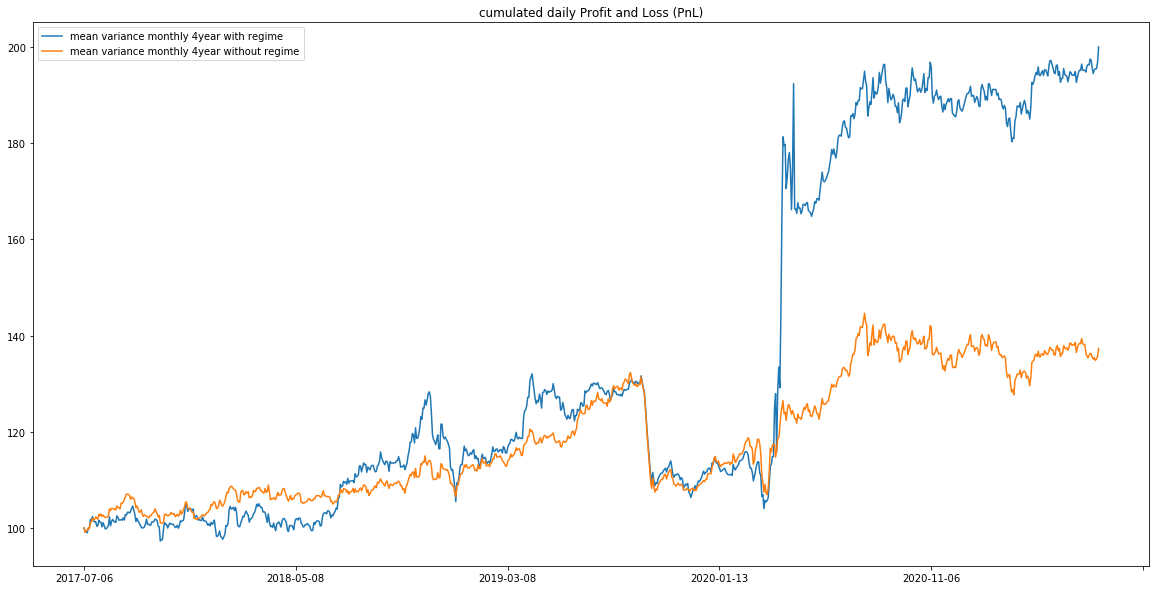

Daily Return Distribution


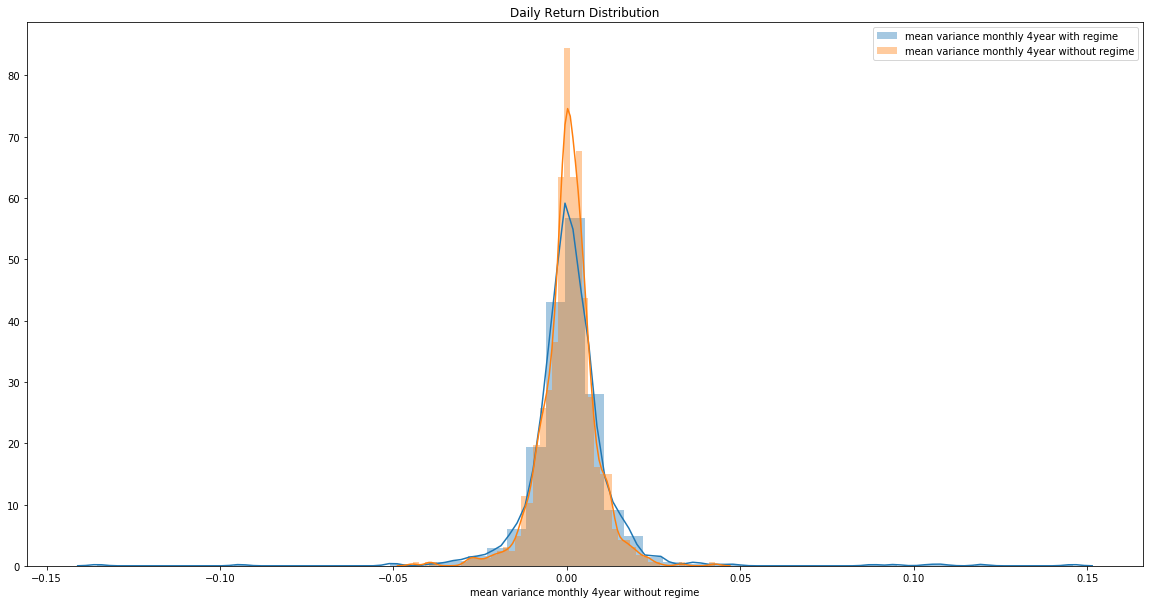

,mean variance monthly 4year with regime,mean variance monthly 4year without regime
Cumulated Return (%),199.999,137.312
Daily Mean Return (%),0.0820714,0.0361511
Daily Min Return (%),-13.5342,-4.45023
Max 10 Days Drawdown (%),36.6582,16.7986
Volatility Daily Price,36.1446,12.739
Volatility Daily Return (%),1.40306,0.780203
Sharpe Ratio,0.0584947,0.0463354
Daily Return Skewness,1.85684,-0.459112
Daily Return Kurtosis,37.8396,4.44622
Modified VaR (%),20.4688,-1.95077


In [342]:
Features_table(pd.concat([Portfolio_performance(mean_variance_weight_monthly_4year,"mean variance monthly 4year with regime"),Portfolio_performance(mean_variance_weight_monthly_4year_withoutregime,"mean variance monthly 4year without regime")],axis = 1))

<font size="4"> Step6.1.2 Mean Variance Strategy: Monthly 2 year with or without market regime

In [292]:
#monthly_2year_df = pd.concat([Portfolio_performance(mean_variance_weight_monthly,"mean variance monthly"),Portfolio_performance(mean_variance_weight_monthly_2year_withoutregime,"mean variance monthly 2year without regime")],axis = 1)
#monthly_2year_df["difference"] = monthly_2year_df["mean variance monthly"] - monthly_2year_df["mean variance monthly 2year without regime"]
#monthly_2year_df.to_excel("monthly 2 year with or without market regime performance.xlsx")

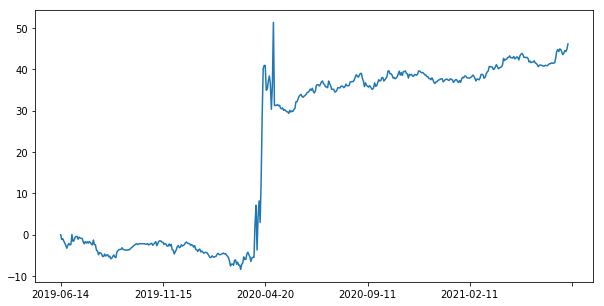

In [301]:
plt.figure(figsize = (10,5))
monthly_2year_df["difference"].plot()

<Figure size 2880x720 with 0 Axes>

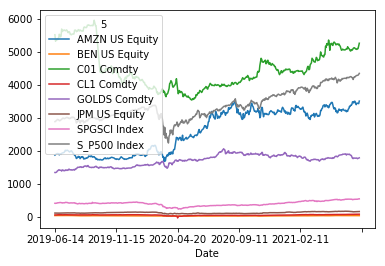

In [308]:
plt.figure(figsize = (40,10))
df.loc["2019-06-14":].plot()

Text(0.5, 1.0, 'S_P500 Index 4-year Trend')

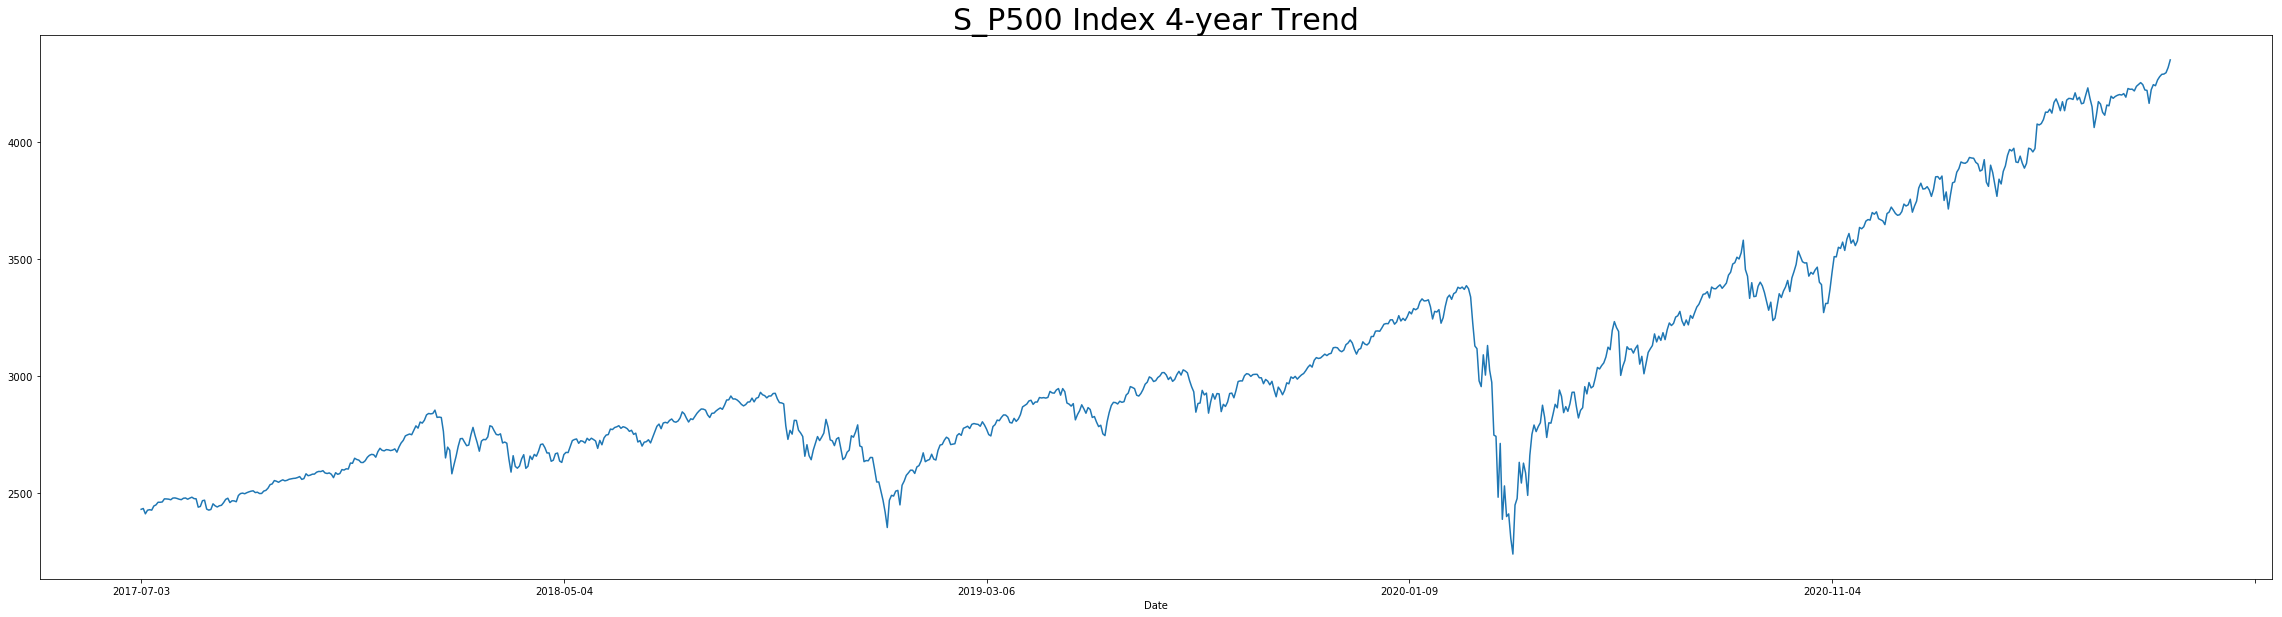

In [326]:
plt.figure(figsize = (40,10))
df["S_P500 Index"].loc["2017-07-03":].plot()
plt.title("S_P500 Index 4-year Trend",fontsize=30)

Text(0.5, 1.0, 'SPGSCI Index 4-year Trend')

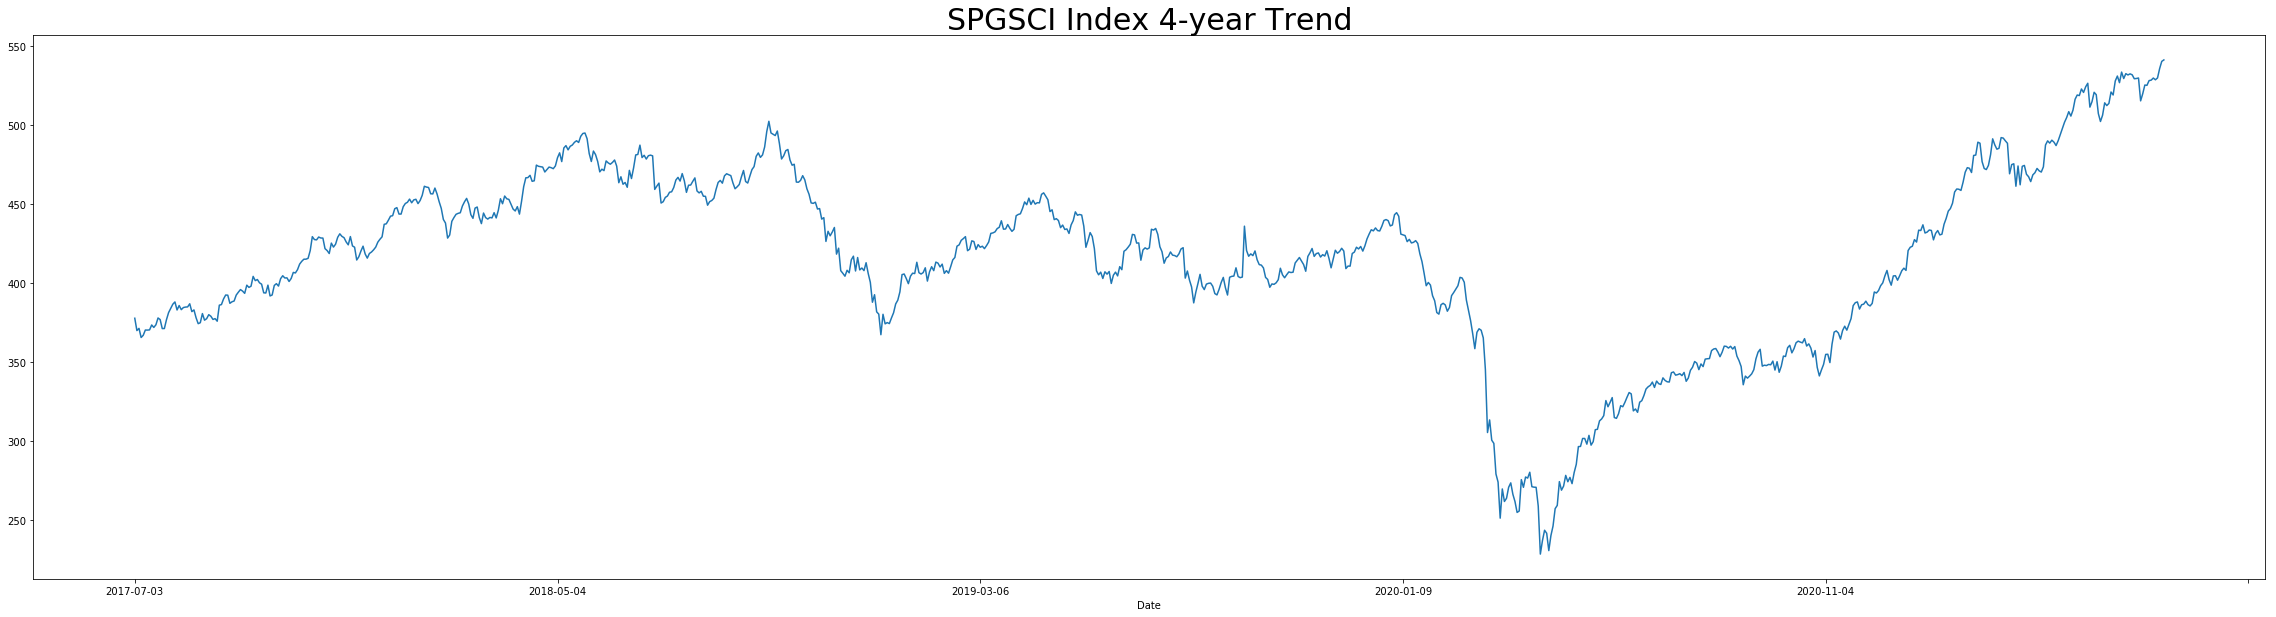

In [327]:
plt.figure(figsize = (40,10))
df["SPGSCI Index"].loc["2017-07-03":].plot()
plt.title("SPGSCI Index 4-year Trend",fontsize = 30)

In [300]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
df.loc["2019-06-14":]

5,AMZN US Equity,BEN US Equity,C01 Comdty,CL1 Comdty,GOLDS Comdty,JPM US Equity,SPGSCI Index,S_P500 Index
Date,,,,,,,,
2019-06-14,1869.67,33.36,5526,52.51,1341.7,109.82,406.96,2886.98
2019-06-17,1886.03,32.86,5328,51.93,1339.66,109.22,404.564,2889.67
2019-06-18,1901.37,33.52,5380,53.9,1346.61,110.71,410.409,2917.75
2019-06-19,1908.79,33.88,5358,53.76,1360.38,109.91,408.493,2926.46
2019-06-20,1918.19,34.54,5414,56.65,1388.44,110.19,420.164,2954.18
2019-06-21,1911.3,34.24,5390,57.43,1399.63,109.44,421.156,2950.46
2019-06-24,1913.9,34.35,5386,57.9,1419.72,108.66,422.806,2945.35
2019-06-25,1878.27,33.78,5540,57.83,1423.44,107.76,424.632,2917.38
2019-06-26,1897.83,34.31,5518,59.38,1409,108.48,430.868,2913.78


In [10]:
mean_variance_weight_monthly_4year = pd.read_csv("C:/Users/Hanlu Ni/Desktop/my documents/Spring2021/capstone/码/mean_variance_weight_monthly_4year.csv")
mean_variance_weight_monthly_4year.set_index("Unnamed: 0")


,AMZN US Equity,BEN US Equity,C01 Comdty,CL1 Comdty,GOLDS Comdty,JPM US Equity
Unnamed: 0,,,,,,
2017-07-06,0.201951,0.178488,0.160044,0.142438,0.153211,0.163869
2017-08-04,0.203550,0.178222,0.159423,0.142585,0.152747,0.163473
2017-09-07,0.204380,0.177446,0.160103,0.141913,0.153701,0.162457
2017-10-09,0.203792,0.178457,0.159264,0.142095,0.152696,0.163695
2017-11-08,0.208243,0.176661,0.155604,0.144356,0.151789,0.163346
2017-12-08,0.207228,0.177175,0.154018,0.145038,0.152482,0.164059
2018-01-10,0.208171,0.176166,0.151822,0.146475,0.153014,0.164351
2018-02-12,0.208562,0.173855,0.154469,0.145568,0.152430,0.165117
2018-03-16,0.208828,0.173073,0.154499,0.146403,0.152115,0.165083


In [11]:
mean_variance_weight_monthly_4year_withoutregime = pd.read_csv("C:/Users/Hanlu Ni/Desktop/my documents/Spring2021/capstone/码/mean_variance_weight_monthly_4year_withoutregime.csv")
mean_variance_weight_monthly_4year_withoutregime.set_index("Unnamed: 0")


,AMZN US Equity,BEN US Equity,C01 Comdty,CL1 Comdty,GOLDS Comdty,JPM US Equity
Unnamed: 0,,,,,,
2017-07-06,0.170114,0.014405,0.065884,-0.052231,0.744489,0.057338
2017-08-04,0.170728,0.013257,0.065964,-0.052025,0.744526,0.057549
2017-09-07,0.154193,0.016865,0.060387,-0.041980,0.745281,0.065254
2017-10-09,0.171339,0.015770,0.064982,-0.050067,0.738144,0.059832
2017-11-08,0.178709,0.013968,0.065898,-0.053617,0.735822,0.059222
2017-12-08,0.192407,0.010561,0.070018,-0.060484,0.730128,0.057369
2018-01-10,0.187221,0.011997,0.068080,-0.057872,0.731254,0.059320
2018-02-12,0.176006,0.013242,0.064825,-0.052278,0.734117,0.064088
2018-03-16,0.183319,0.011189,0.066235,-0.055528,0.731813,0.062971


In [22]:
mean_variance_weight_monthly_2year = pd.read_csv("C:/Users/Hanlu Ni/Desktop/my documents/Spring2021/capstone/码/mean_variance_weight_monthly_2year.csv")
mean_variance_weight_monthly_2year.set_index("Unnamed: 0")


,AMZN US Equity,BEN US Equity,C01 Comdty,CL1 Comdty,GOLDS Comdty,JPM US Equity
Unnamed: 0,,,,,,
2019-06-14,0.207929,0.169228,0.156065,0.149618,0.154433,0.162727
2019-07-16,0.209234,0.169325,0.155179,0.149759,0.153988,0.162515
2019-08-16,0.209516,0.166413,0.156138,0.149647,0.155870,0.162415
2019-09-18,0.210814,0.166836,0.155535,0.149159,0.154478,0.163179
2019-10-22,0.192104,0.136268,0.133894,-0.029134,0.371129,0.195739
2019-11-22,0.208037,0.166648,0.152326,0.151218,0.156043,0.165728
2019-12-24,0.208802,0.165685,0.151956,0.151496,0.155909,0.166152
2020-01-27,0.184710,0.129591,0.130394,-0.029696,0.384385,0.200616
2020-02-26,0.176788,0.124583,0.131628,-0.030062,0.398357,0.198707


In [298]:
mean_variance_weight_monthly_2year_withoutregime

5,AMZN US Equity,BEN US Equity,C01 Comdty,CL1 Comdty,GOLDS Comdty,JPM US Equity
2019-06-14,0.166614,0.013946,0.066907,-0.045730,0.732728,0.065535
2019-07-16,0.169953,0.012525,0.068037,-0.048063,0.732408,0.065141
2019-08-16,0.168059,0.006804,0.064443,-0.040617,0.729876,0.071435
2019-09-18,0.207189,0.146335,0.184272,0.140853,0.164192,0.157160
2019-10-22,0.155313,0.007788,0.058757,-0.037189,0.734368,0.080962
2019-11-22,0.146361,0.010027,0.057158,-0.032438,0.735519,0.083374
2019-12-24,0.145743,0.010221,0.056947,-0.032356,0.735545,0.083901
2020-01-27,0.123942,0.018770,0.051554,-0.019277,0.735990,0.089022
2020-02-26,0.117661,0.017177,0.049728,-0.015773,0.737663,0.093545
2020-03-27,0.122975,0.016626,0.056646,-0.030479,0.738946,0.095286


Cumulated Daily Profit and Loss (PnL)


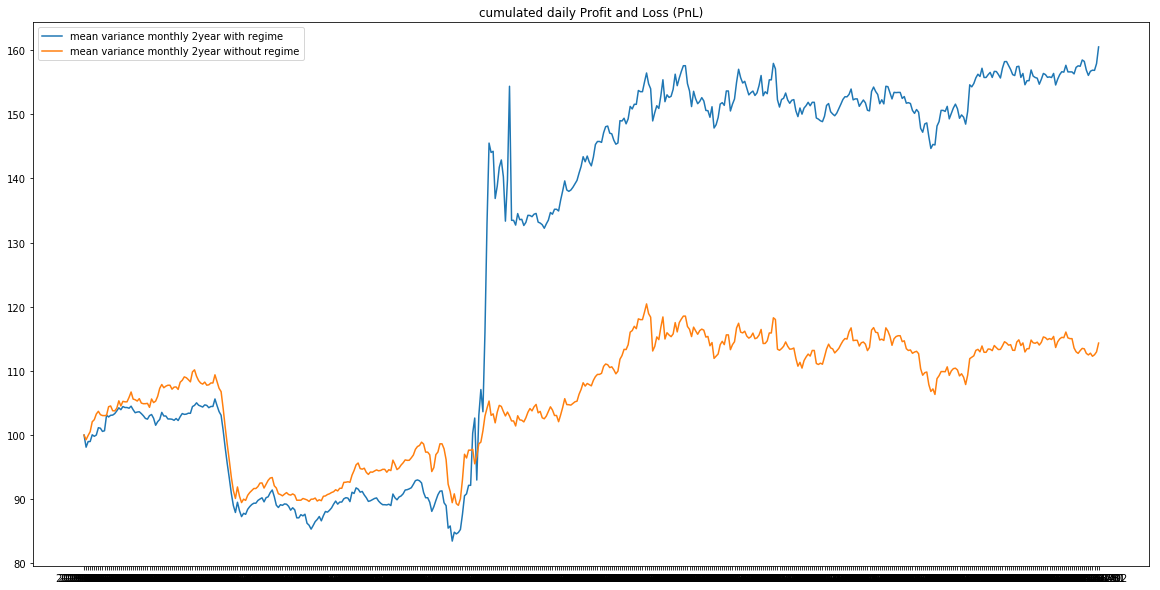

Daily Return Distribution


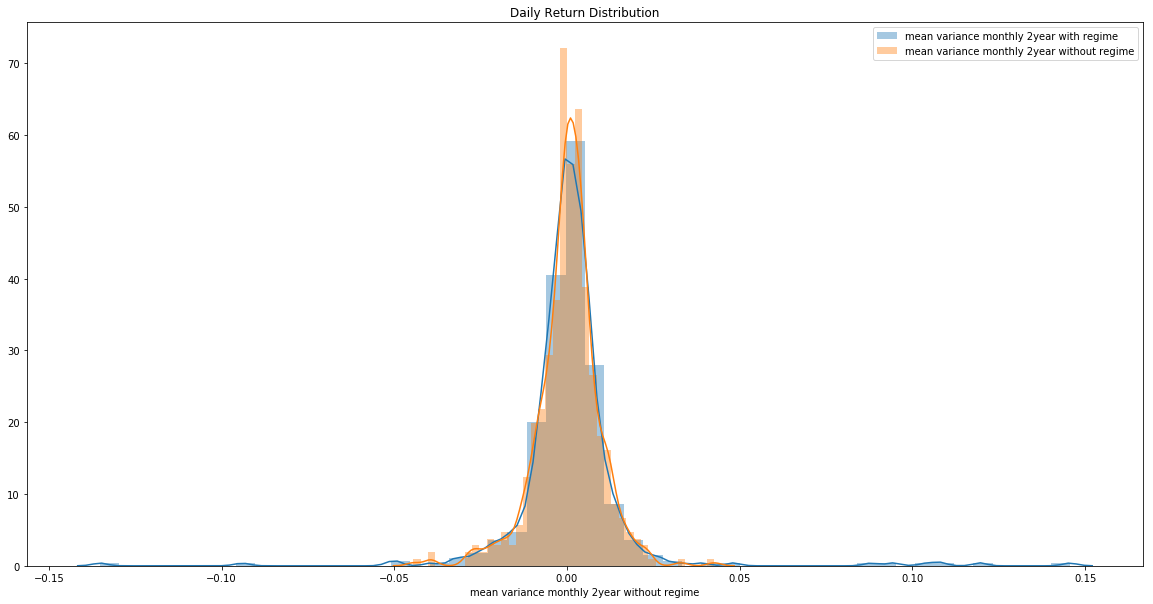

,mean variance monthly 2year with regime,mean variance monthly 2year without regime
Cumulated Return (%),160.5,114.341
Daily Mean Return (%),0.110107,0.0313163
Daily Min Return (%),-13.5342,-4.45023
Max 10 Days Drawdown (%),36.6582,16.7986
Volatility Daily Price,28.001,8.76513
Volatility Daily Return (%),1.73012,0.926071
Sharpe Ratio,0.0636414,0.0338163
Daily Return Skewness,1.84998,-0.560976
Daily Return Kurtosis,30.755,3.60087
Modified VaR (%),12.9409,-2.22478


In [315]:
Features_table(pd.concat([Portfolio_performance(mean_variance_weight_monthly,"mean variance monthly 2year with regime"),Portfolio_performance(mean_variance_weight_monthly_2year_withoutregime,"mean variance monthly 2year without regime")],axis = 1))

<font size="4"> Step6.1.1.2 Mean Variance Strategy: Weekly 1 year with or without market regime

Cumulated Daily Profit and Loss (PnL)


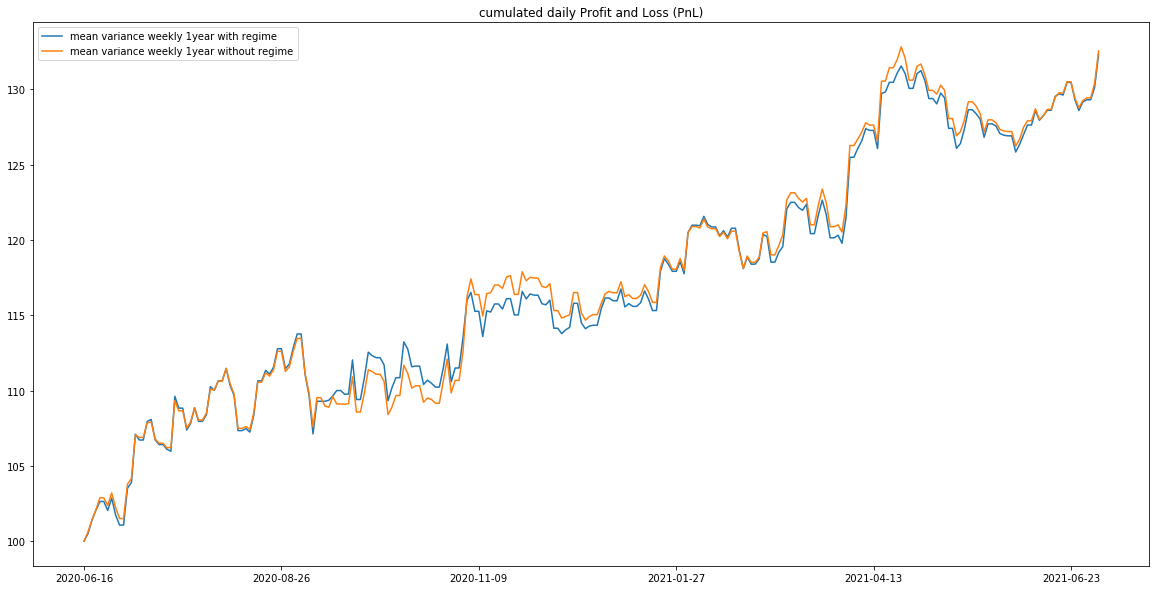

Daily Return Distribution


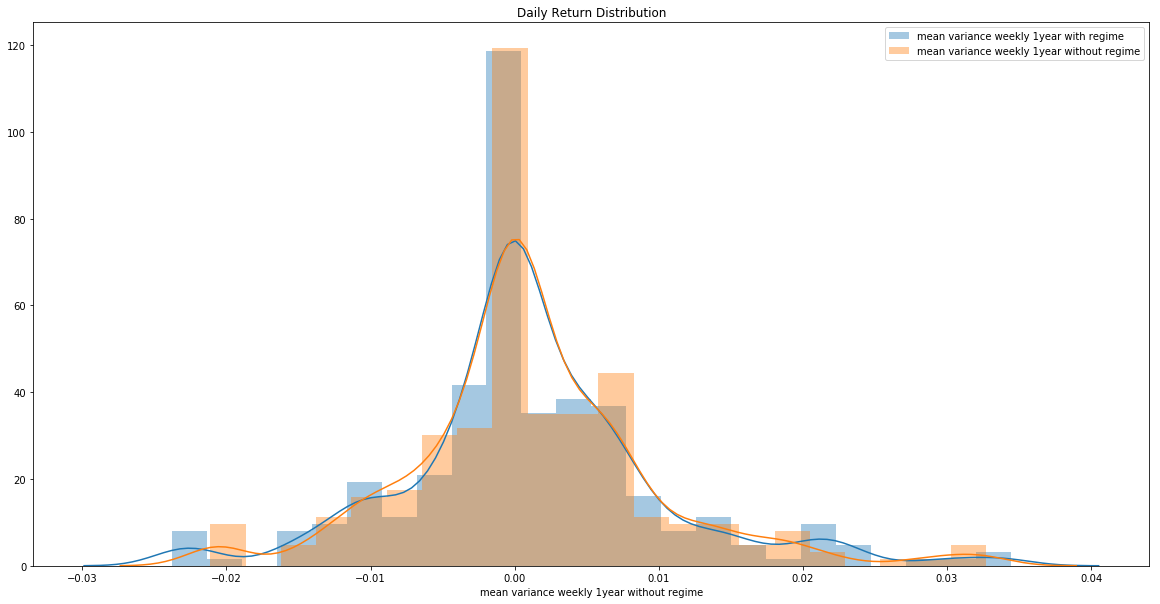

,mean variance weekly 1year with regime,mean variance weekly 1year without regime
Cumulated Return (%),132.335,132.568
Daily Mean Return (%),0.113151,0.113423
Daily Min Return (%),-2.37839,-2.1108
Max 10 Days Drawdown (%),6.49412,7.0374
Volatility Daily Price,8.08734,8.31711
Volatility Daily Return (%),0.906765,0.859805
Sharpe Ratio,0.124786,0.131917
Daily Return Skewness,0.50301,0.625671
Daily Return Kurtosis,2.1055,2.27037
Modified VaR (%),-1.83634,-1.76162


In [31]:
import numpy as np
import seaborn as sns
#mean_variance_weight_weekly = pd.read_csv("C:/Users/Hanlu Ni/Desktop/my documents/Spring2021/capstone/码/mean_variance_weight_weekly_1year.csv").set_index("Unnamed: 0")
#mean_variance_weight_weekly_1year_withoutregime = pd.read_csv("C:/Users/Hanlu Ni/Desktop/my documents/Spring2021/capstone/码/mean_variance_weight_weekly_1year_withoutregime.csv").set_index("Unnamed: 0")
Features_table(pd.concat([Portfolio_performance(mean_variance_weight_weekly,"mean variance weekly 1year with regime"),Portfolio_performance(mean_variance_weight_weekly_1year_withoutregime,"mean variance weekly 1year without regime")],axis = 1))

<font size="4"> Step6.1.2 Minimum Variance Strategy: Monthly 2 year with or without market regime

Cumulated Daily Profit and Loss (PnL)


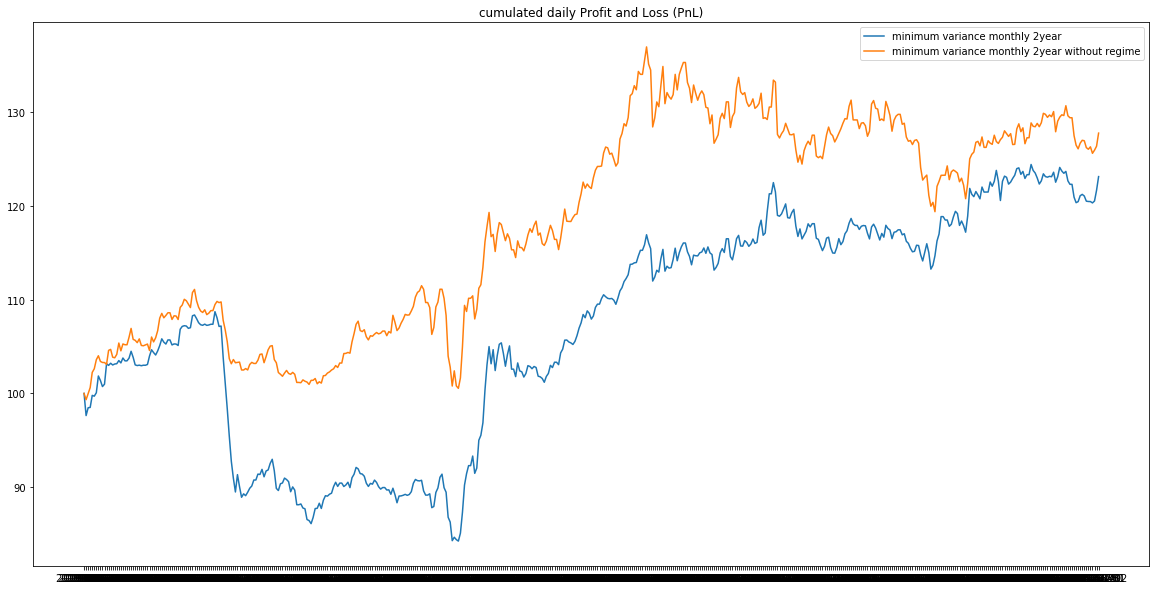

Daily Return Distribution


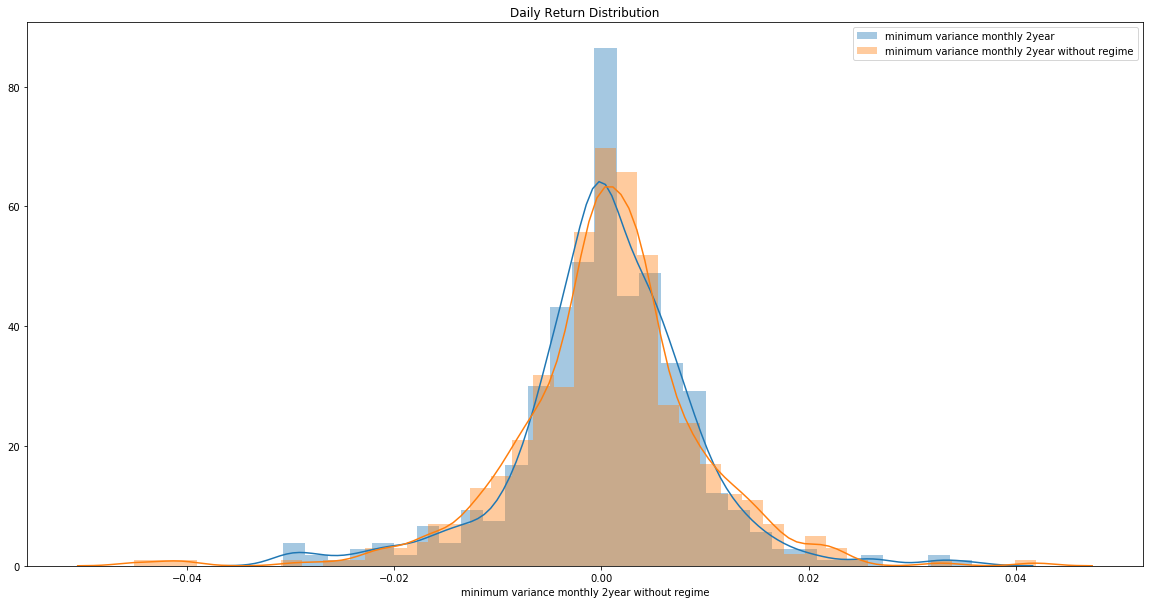

,minimum variance monthly 2year,minimum variance monthly 2year without regime
Cumulated Return (%),123.093,127.725
Daily Mean Return (%),0.0455943,0.0533812
Daily Min Return (%),-3.07256,-4.50841
Max 10 Days Drawdown (%),17.1715,9.51123
Volatility Daily Price,11.8307,11.0318
Volatility Daily Return (%),0.860203,0.89785
Sharpe Ratio,0.0530041,0.0594545
Daily Return Skewness,-0.251633,-0.483538
Daily Return Kurtosis,2.79402,4.00981
Modified VaR (%),-1.93074,-2.18445


In [264]:
Features_table(pd.concat([Portfolio_performance(minimum_variance_weight_monthly_2year,"minimum variance monthly 2year"),Portfolio_performance(minimum_variance_weight_monthly_2year_withoutregime,"minimum variance monthly 2year without regime")],axis = 1))

<font size="4"> Step6.1.3 Max Diversification Strategy: Monthly 2 year with or without market regime

Cumulated Daily Profit and Loss (PnL)


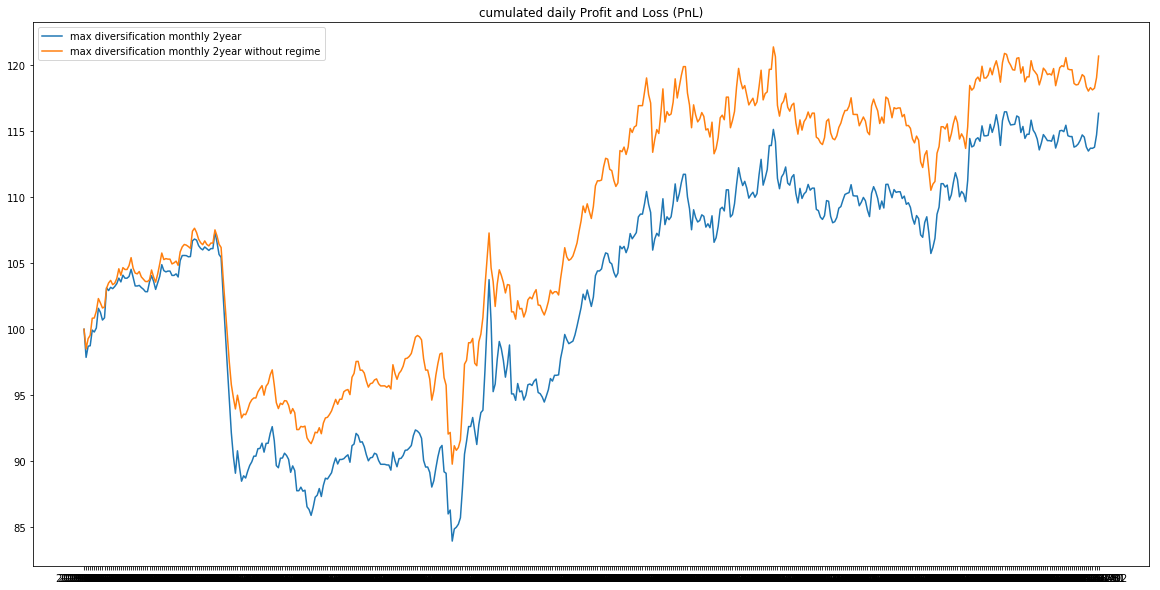

Daily Return Distribution


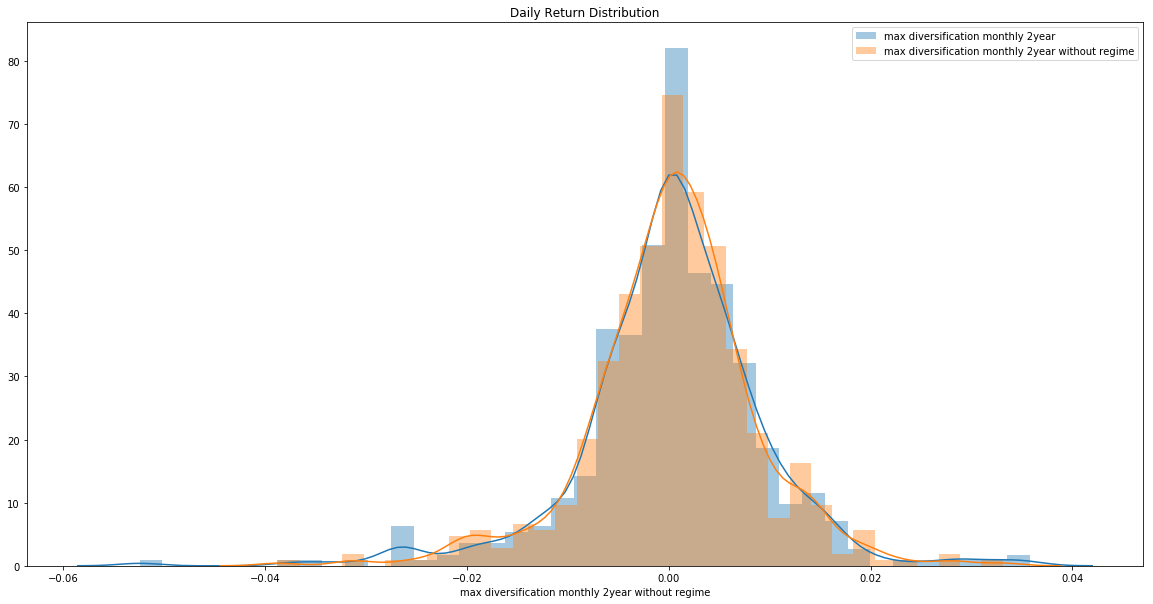

,max diversification monthly 2year,max diversification monthly 2year without regime
Cumulated Return (%),116.353,120.685
Daily Mean Return (%),0.0348363,0.0414226
Daily Min Return (%),-5.24093,-3.86694
Max 10 Days Drawdown (%),16.402,12.239
Volatility Daily Price,9.09346,9.31063
Volatility Daily Return (%),0.926012,0.837802
Sharpe Ratio,0.0376196,0.049442
Daily Return Skewness,-0.620255,-0.365172
Daily Return Kurtosis,4.34727,2.5132
Modified VaR (%),-2.31552,-1.84194


In [265]:
Features_table(pd.concat([Portfolio_performance(max_diversification_weight_monthly_2year,"max diversification monthly 2year"),Portfolio_performance(max_diversification_weight_monthly_2year_withoutregime,"max diversification monthly 2year without regime")],axis = 1))

<font size="5"> Step6.2 compare portfolio performance with or without rebalance

<font size="4"> Step6.2.1 Mean Variance Strategy Monthly 4 year with or without rebalance

Cumulated Daily Profit and Loss (PnL)


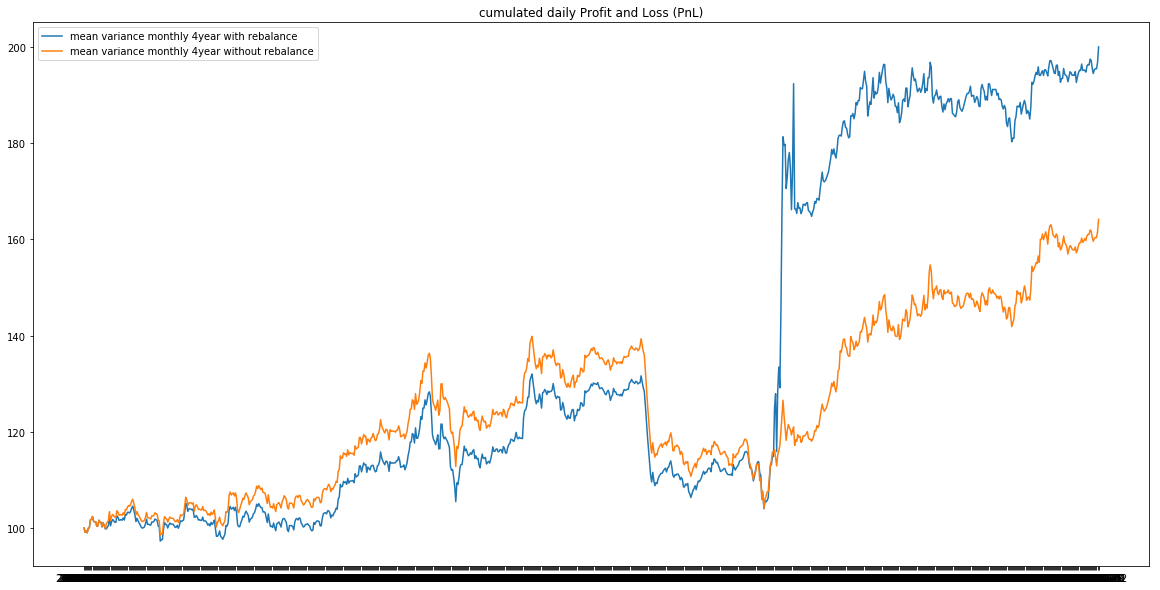

Daily Return Distribution


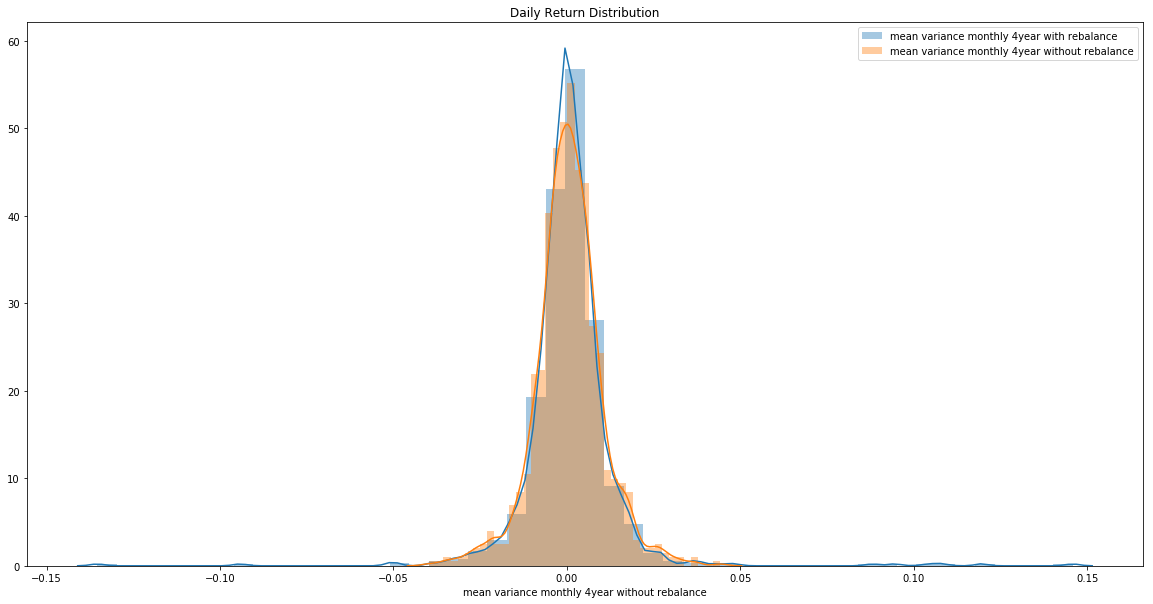

,mean variance monthly 4year with rebalance,mean variance monthly 4year without rebalance
Cumulated Return (%),199.999,164.181
Daily Mean Return (%),0.0820714,0.056509
Daily Min Return (%),-13.5342,-3.97897
Max 10 Days Drawdown (%),36.6582,16.246
Volatility Daily Price,36.1446,17.4088
Volatility Daily Return (%),1.40306,0.97452
Sharpe Ratio,0.0584947,0.0579865
Daily Return Skewness,1.85684,-0.0130806
Daily Return Kurtosis,37.8396,2.11178
Modified VaR (%),20.4688,-2.05005


In [331]:

Features_table(pd.concat([Portfolio_performance(mean_variance_weight_monthly_4year,"mean variance monthly 4year with rebalance"),Portfolio_performance_withoutrebalance(mean_variance_weight_monthly_4year,"mean variance monthly 4year without rebalance")],axis = 1))

<font size="4"> Step6.2.2 Mean Variance Strategy Monthly 2 year with or without rebalance

Cumulated Daily Profit and Loss (PnL)


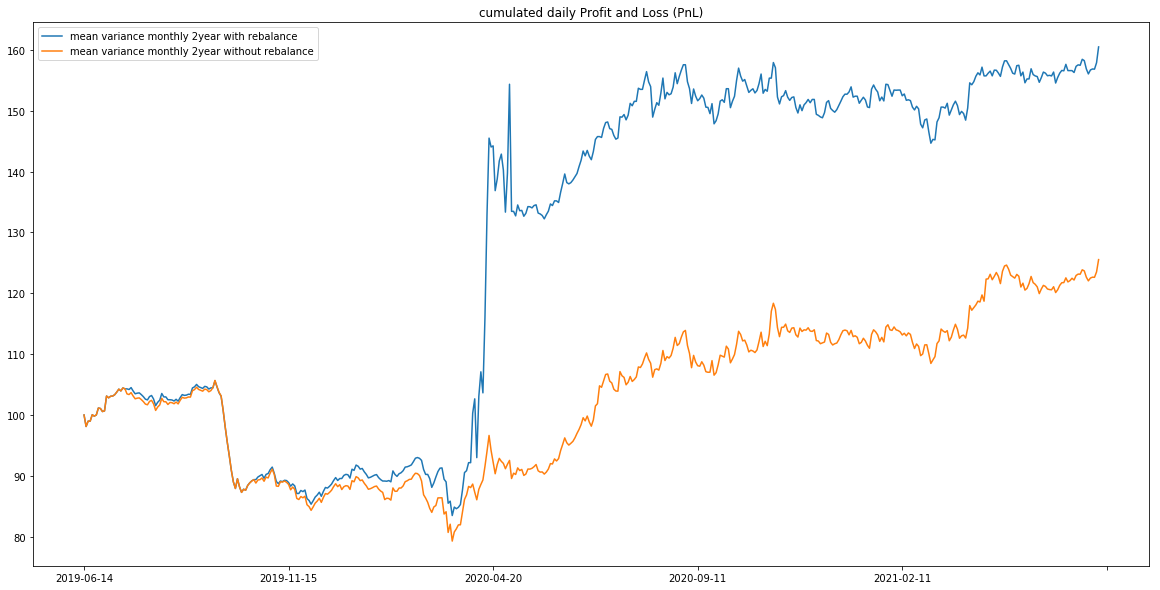

Daily Return Distribution


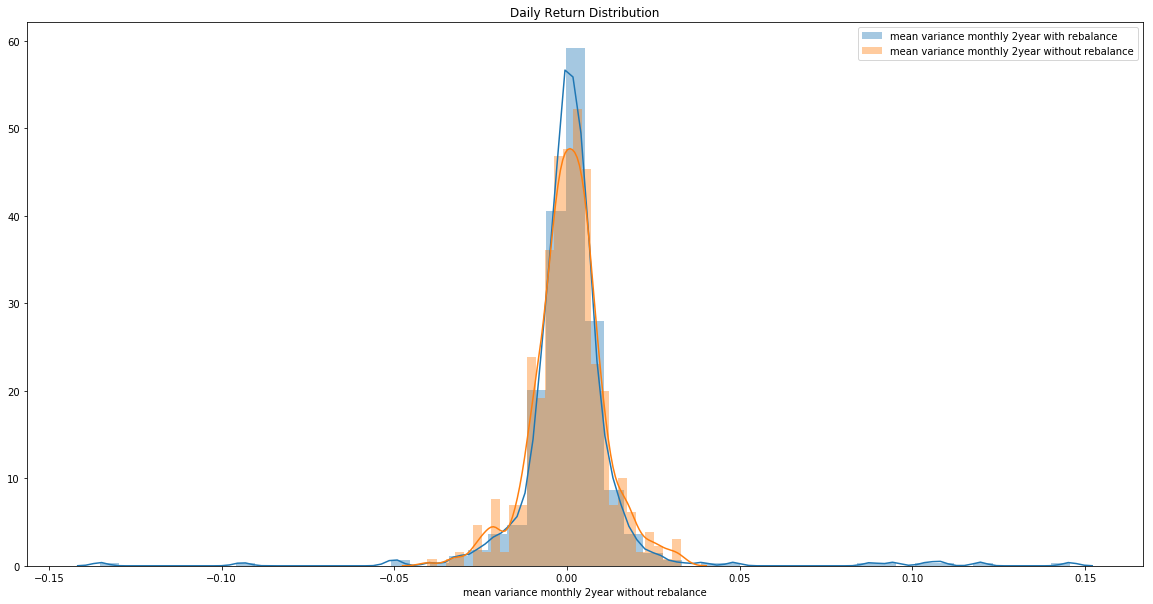

,mean variance monthly 2year with rebalance,mean variance monthly 2year without rebalance
Cumulated Return (%),160.5,125.541
Daily Mean Return (%),0.110107,0.0509674
Daily Min Return (%),-13.5342,-4.04012
Max 10 Days Drawdown (%),36.6582,15.9984
Volatility Daily Price,28.001,12.1083
Volatility Daily Return (%),1.73012,1.01036
Sharpe Ratio,0.0636414,0.0504449
Daily Return Skewness,1.84998,-0.158199
Daily Return Kurtosis,30.755,1.65988
Modified VaR (%),12.9409,-2.03858


In [36]:
#mean_variance_weight_monthly = pd.read_csv("C:/Users/Hanlu Ni/Desktop/my documents/Spring2021/capstone/码/mean_variance_weight_monthly_2year.csv").set_index("Unnamed: 0")
Features_table(pd.concat([Portfolio_performance(mean_variance_weight_monthly,"mean variance monthly 2year with rebalance"),Portfolio_performance_withoutrebalance(mean_variance_weight_monthly,"mean variance monthly 2year without rebalance")],axis = 1))

<font size="4"> Step6.2.1.2 Mean Variance Strategy Weekly 1 year with or without rebalance

Cumulated Daily Profit and Loss (PnL)


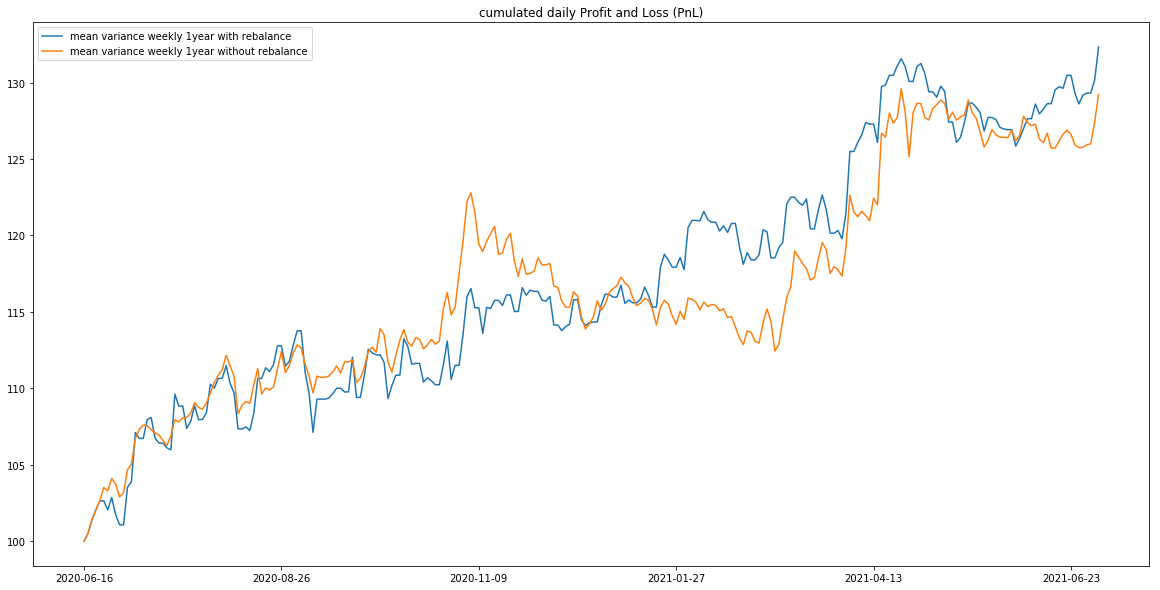

Daily Return Distribution


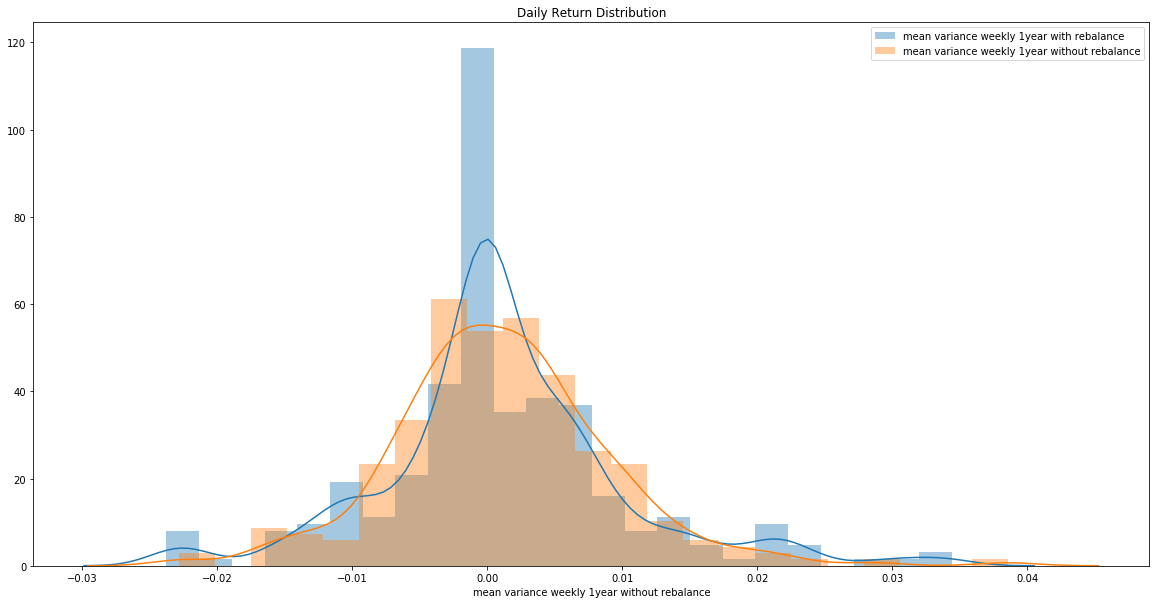

,mean variance weekly 1year with rebalance,mean variance weekly 1year without rebalance
Cumulated Return (%),132.335,129.217
Daily Mean Return (%),0.113151,0.10296
Daily Min Return (%),-2.37839,-2.28666
Max 10 Days Drawdown (%),6.49412,8.07084
Volatility Daily Price,8.08734,7.01323
Volatility Daily Return (%),0.906765,0.799708
Sharpe Ratio,0.124786,0.128748
Daily Return Skewness,0.50301,0.496021
Daily Return Kurtosis,2.1055,2.28112
Modified VaR (%),-1.83634,-1.64483


In [37]:
#mean_variance_weight_weekly = pd.read_csv("C:/Users/Hanlu Ni/Desktop/my documents/Spring2021/capstone/码/mean_variance_weight_weekly_1year.csv").set_index("Unnamed: 0")
Features_table(pd.concat([Portfolio_performance(mean_variance_weight_weekly,"mean variance weekly 1year with rebalance"),Portfolio_performance_withoutrebalance(mean_variance_weight_weekly,"mean variance weekly 1year without rebalance")],axis = 1))

<font size="4"> Step6.2.2 Minimum Variance Strategy Monthly 2 year with or without rebalance

Cumulated Daily Profit and Loss (PnL)


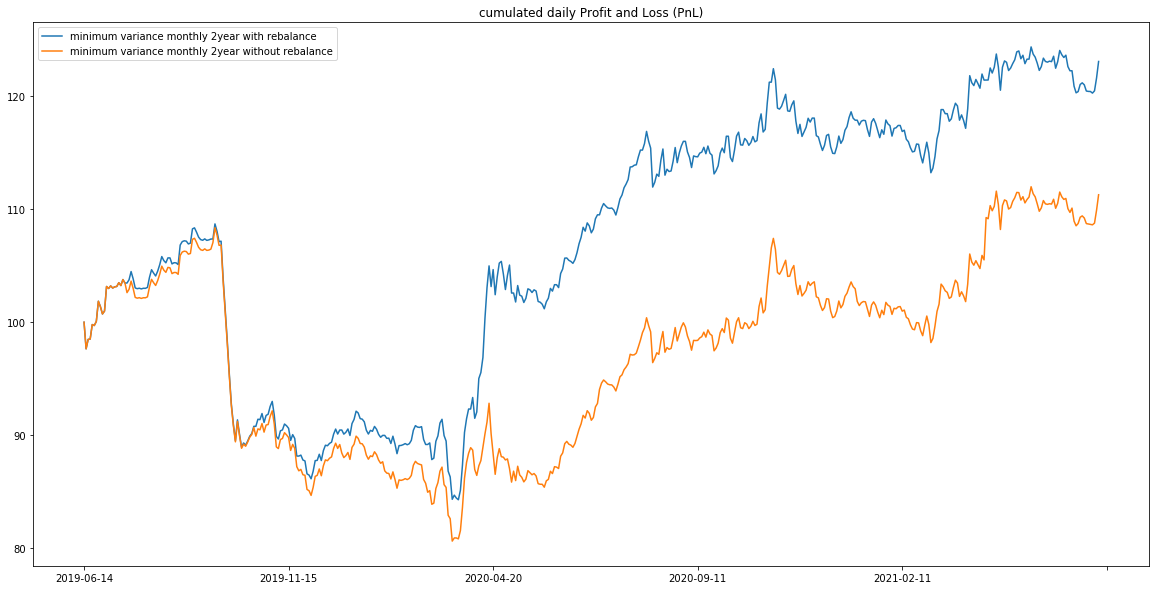

Daily Return Distribution


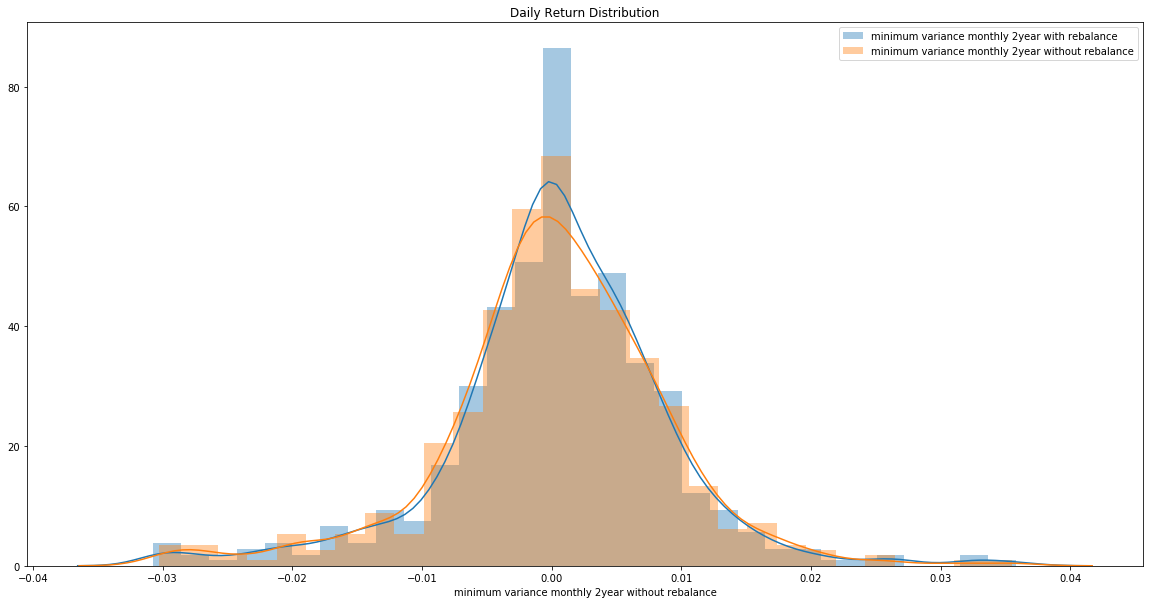

,minimum variance monthly 2year with rebalance,minimum variance monthly 2year without rebalance
Cumulated Return (%),123.093,111.288
Daily Mean Return (%),0.0455943,0.0252784
Daily Min Return (%),-3.07256,-3.0294
Max 10 Days Drawdown (%),17.1715,17.0075
Volatility Daily Price,11.8307,8.2079
Volatility Daily Return (%),0.860203,0.861813
Sharpe Ratio,0.0530041,0.0293316
Daily Return Skewness,-0.251633,-0.357925
Daily Return Kurtosis,2.79402,2.20757
Modified VaR (%),-1.93074,-1.86042


In [38]:
#minimum_variance_weight_monthly_2year = pd.read_csv("C:/Users/Hanlu Ni/Desktop/my documents/Spring2021/capstone/码/minimum_variance_weight_monthly_2year.csv").set_index("Unnamed: 0")
Features_table(pd.concat([Portfolio_performance(minimum_variance_weight_monthly_2year,"minimum variance monthly 2year with rebalance"),Portfolio_performance_withoutrebalance(minimum_variance_weight_monthly_2year,"minimum variance monthly 2year without rebalance")],axis = 1))

<font size="4"> Step6.2.2.2 Minimum Variance Strategy Weekly 1 year with or without rebalance

Cumulated Daily Profit and Loss (PnL)


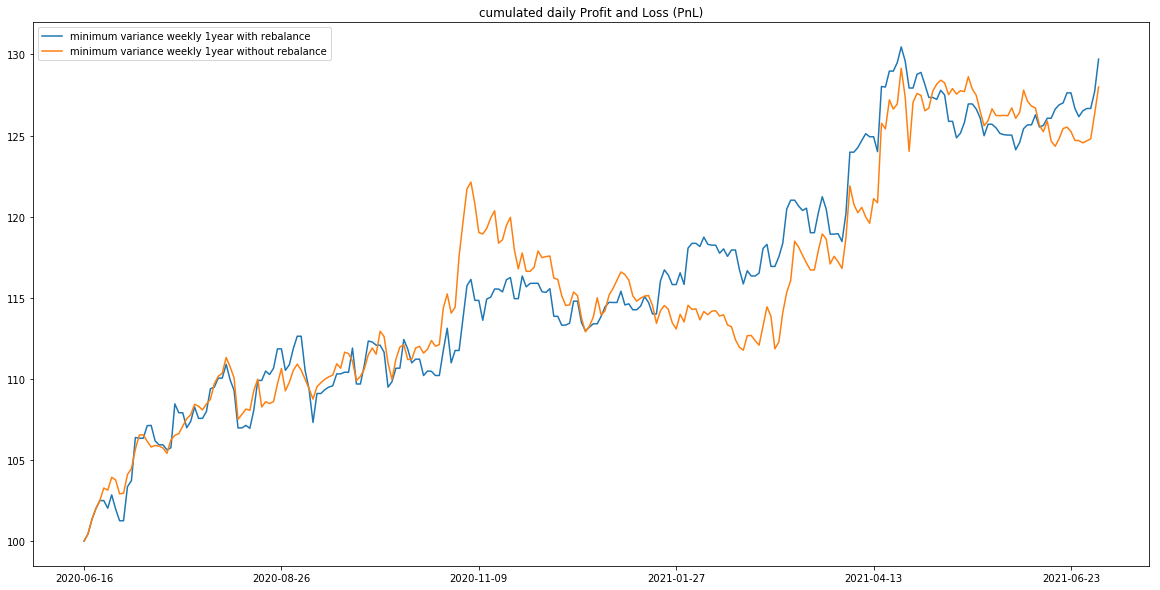

Daily Return Distribution


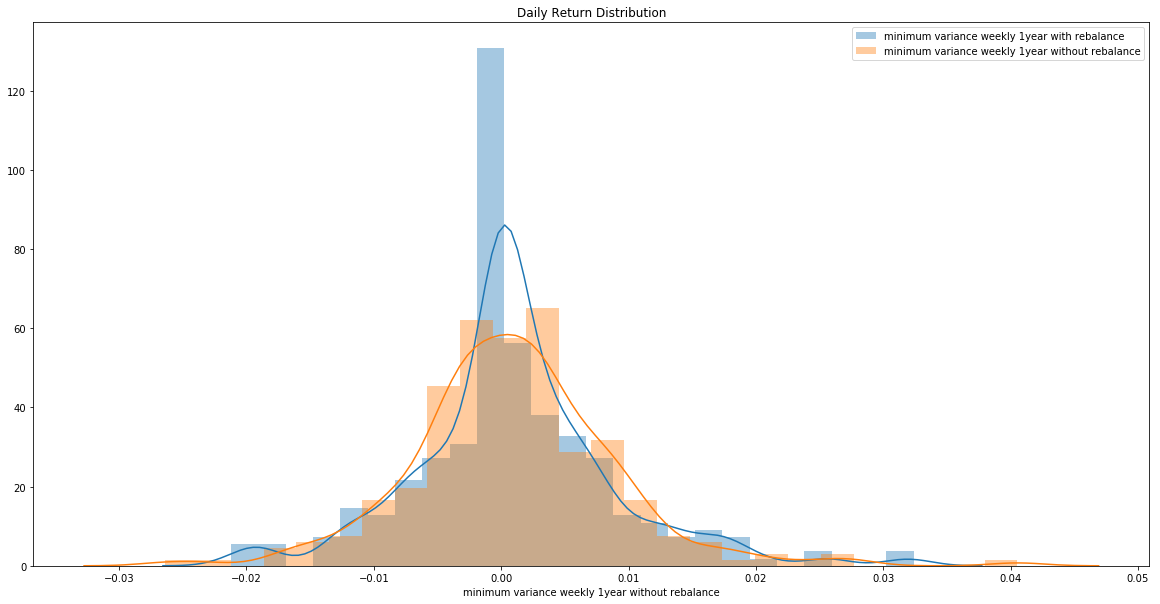

,minimum variance weekly 1year with rebalance,minimum variance weekly 1year without rebalance
Cumulated Return (%),129.711,127.998
Daily Mean Return (%),0.104393,0.0993188
Daily Min Return (%),-2.12039,-2.63816
Max 10 Days Drawdown (%),6.11361,8.28154
Volatility Daily Price,7.3672,7.08627
Volatility Daily Return (%),0.793024,0.806033
Sharpe Ratio,0.131639,0.123219
Daily Return Skewness,0.516915,0.54357
Daily Return Kurtosis,2.23708,3.05474
Modified VaR (%),-1.62149,-1.77628


In [39]:
#minimum_variance_weight_weekly_1year = pd.read_csv("C:/Users/Hanlu Ni/Desktop/my documents/Spring2021/capstone/码/minimum_variance_weight_weekly_1year.csv").set_index("Unnamed: 0")
Features_table(pd.concat([Portfolio_performance(minimum_variance_weight_weekly_1year,"minimum variance weekly 1year with rebalance"),Portfolio_performance_withoutrebalance(minimum_variance_weight_weekly_1year,"minimum variance weekly 1year without rebalance")],axis = 1))

<font size="4"> Step6.2.3 Max Diversification Strategy Monthly 2 year with or without rebalance

Cumulated Daily Profit and Loss (PnL)


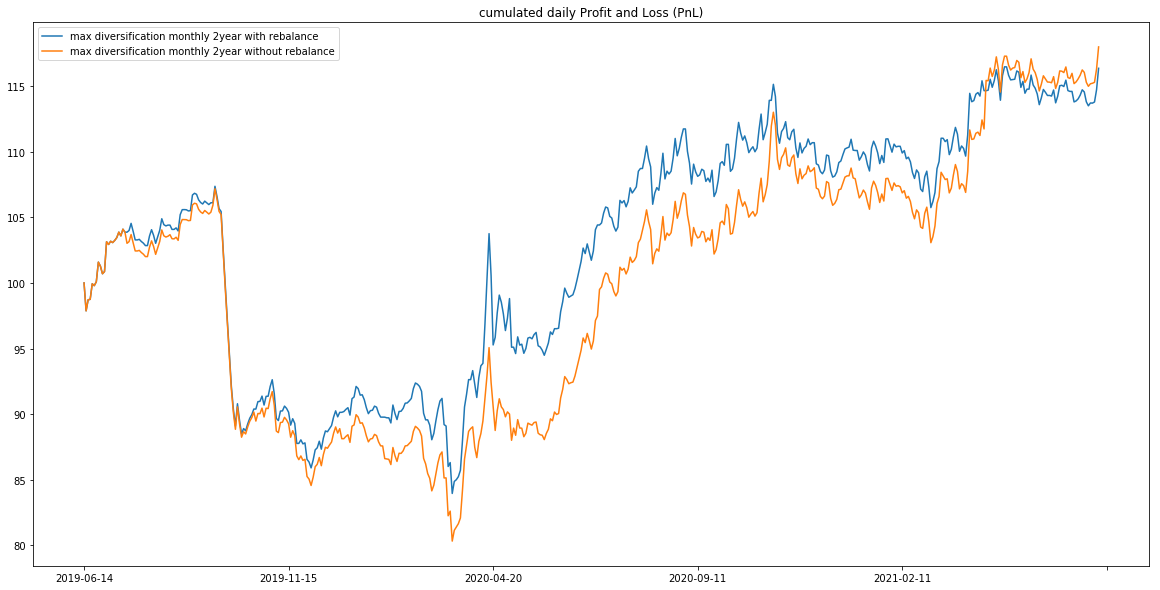

Daily Return Distribution


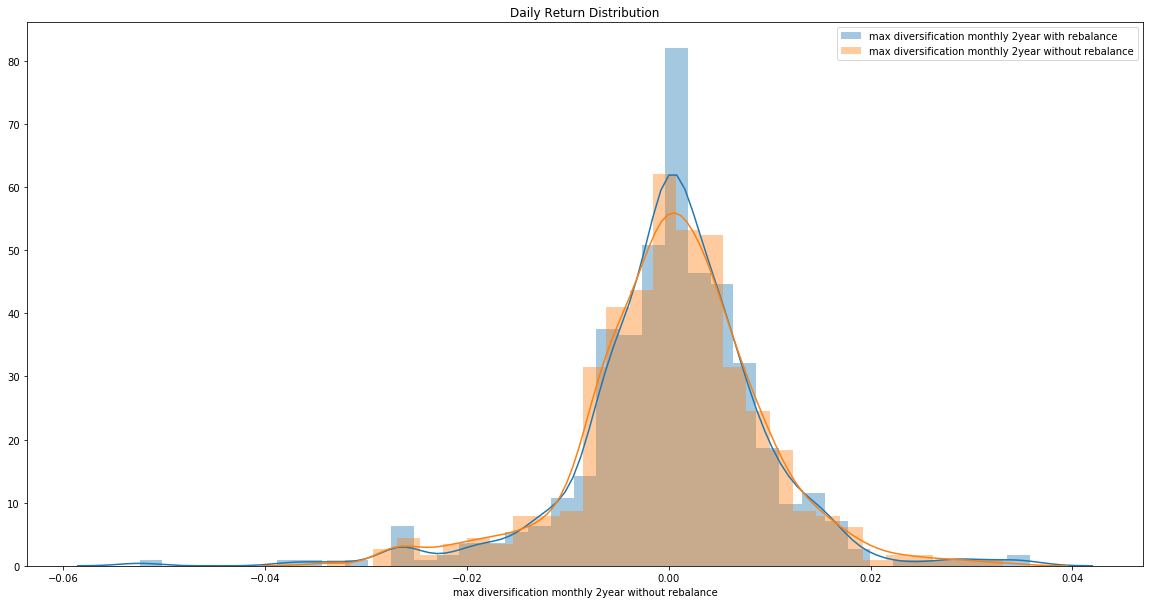

,max diversification monthly 2year with rebalance,max diversification monthly 2year without rebalance
Cumulated Return (%),116.353,117.983
Daily Mean Return (%),0.0348363,0.0373384
Daily Min Return (%),-5.24093,-3.38775
Max 10 Days Drawdown (%),16.402,16.475
Volatility Daily Price,9.09346,9.7987
Volatility Daily Return (%),0.926012,0.893657
Sharpe Ratio,0.0376196,0.0417816
Daily Return Skewness,-0.620255,-0.310908
Daily Return Kurtosis,4.34727,1.80784
Modified VaR (%),-2.31552,-1.84259


In [40]:
#max_diversification_weight_monthly_2year = pd.read_csv("C:/Users/Hanlu Ni/Desktop/my documents/Spring2021/capstone/码/max_diversification_weight_monthly_2year.csv").set_index("Unnamed: 0")
Features_table(pd.concat([Portfolio_performance(max_diversification_weight_monthly_2year,"max diversification monthly 2year with rebalance"),Portfolio_performance_withoutrebalance(max_diversification_weight_monthly_2year,"max diversification monthly 2year without rebalance")],axis = 1))

<font size="4"> Step6.2.3.2 Max Diversification Strategy Weekly 1 year with or without rebalance

Cumulated Daily Profit and Loss (PnL)


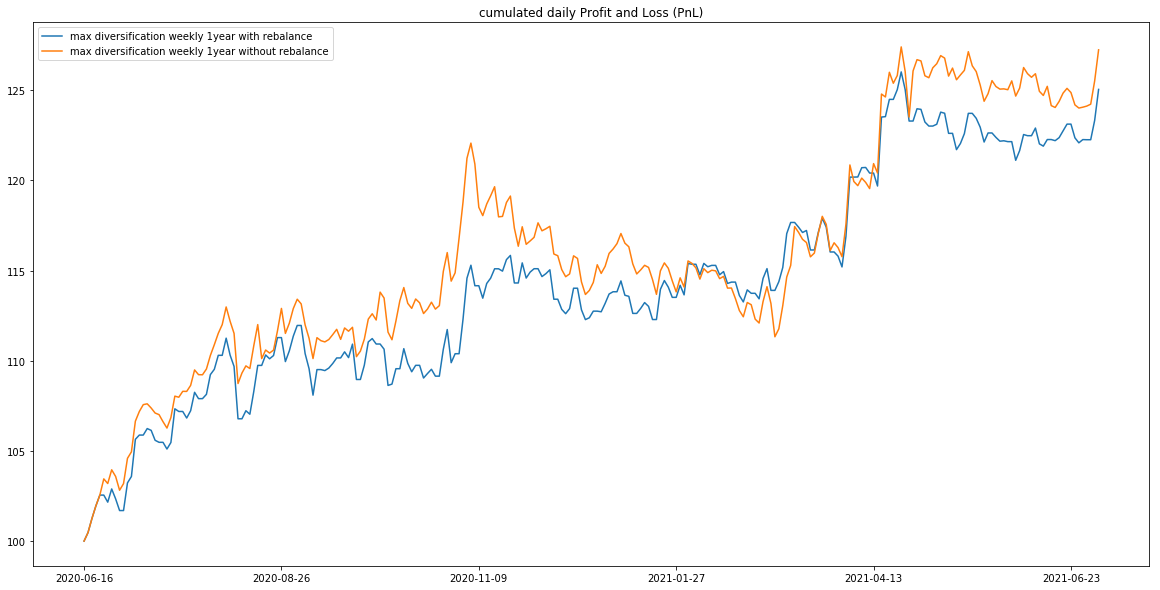

Daily Return Distribution


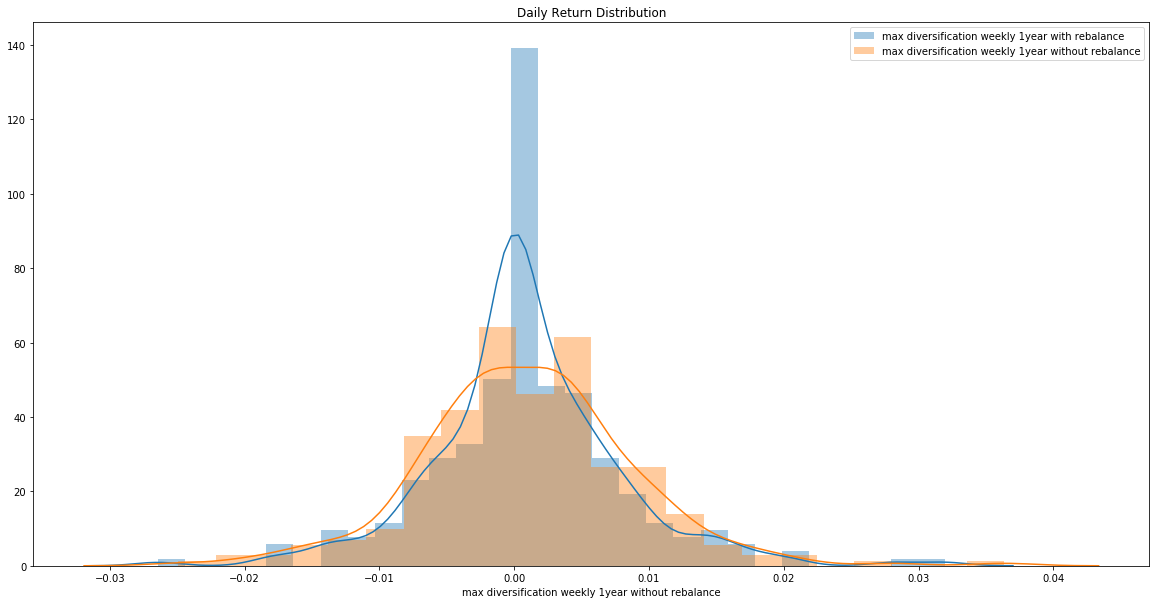

,max diversification weekly 1year with rebalance,max diversification weekly 1year without rebalance
Cumulated Return (%),125.04,127.235
Daily Mean Return (%),0.0894578,0.0968233
Daily Min Return (%),-2.64468,-2.49173
Max 10 Days Drawdown (%),5.35405,7.53931
Volatility Daily Price,5.97604,6.33423
Volatility Daily Return (%),0.704999,0.78458
Sharpe Ratio,0.126891,0.123408
Daily Return Skewness,0.377787,0.316548
Daily Return Kurtosis,2.94141,2.02098
Modified VaR (%),-1.53968,-1.57922


In [41]:
#max_diversification_weight_weekly_1year = pd.read_csv("C:/Users/Hanlu Ni/Desktop/my documents/Spring2021/capstone/码/max_diversification_weight_weekly_1year.csv").set_index("Unnamed: 0")
Features_table(pd.concat([Portfolio_performance(max_diversification_weight_weekly_1year,"max diversification weekly 1year with rebalance"),Portfolio_performance_withoutrebalance(max_diversification_weight_weekly_1year,"max diversification weekly 1year without rebalance")],axis = 1))

<font size="5"> Step6.3 compare portfolio performance weekly or monthly reblance

<font size="4"> Step6.3.1 Mean Variance Strategy: compare portfolio performance weekly or monthly reblance

Cumulated Daily Profit and Loss (PnL)


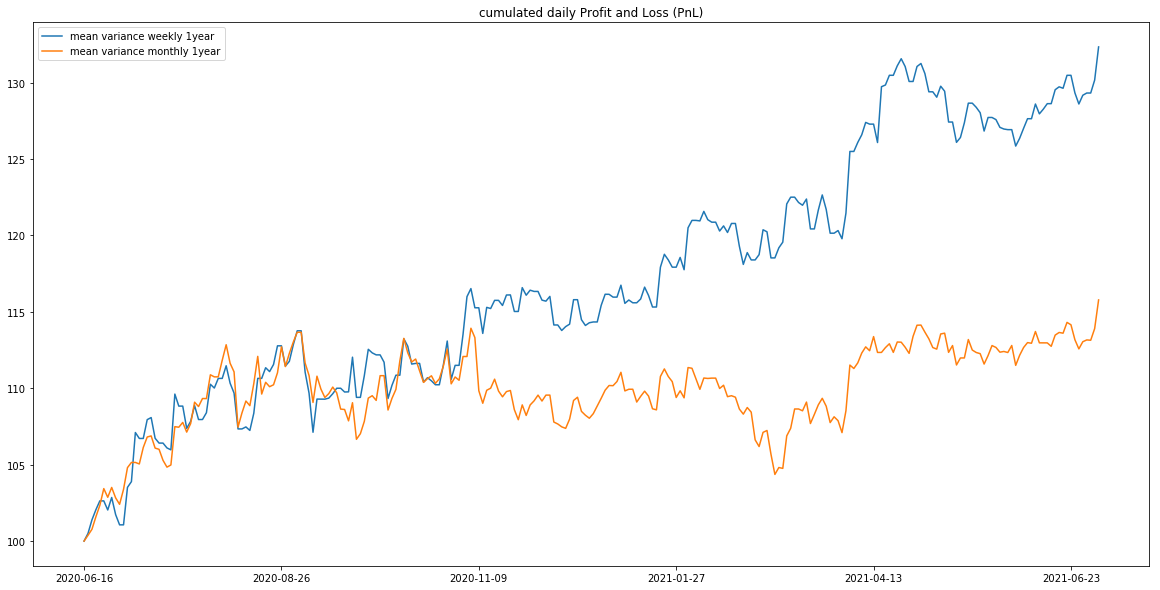

Daily Return Distribution


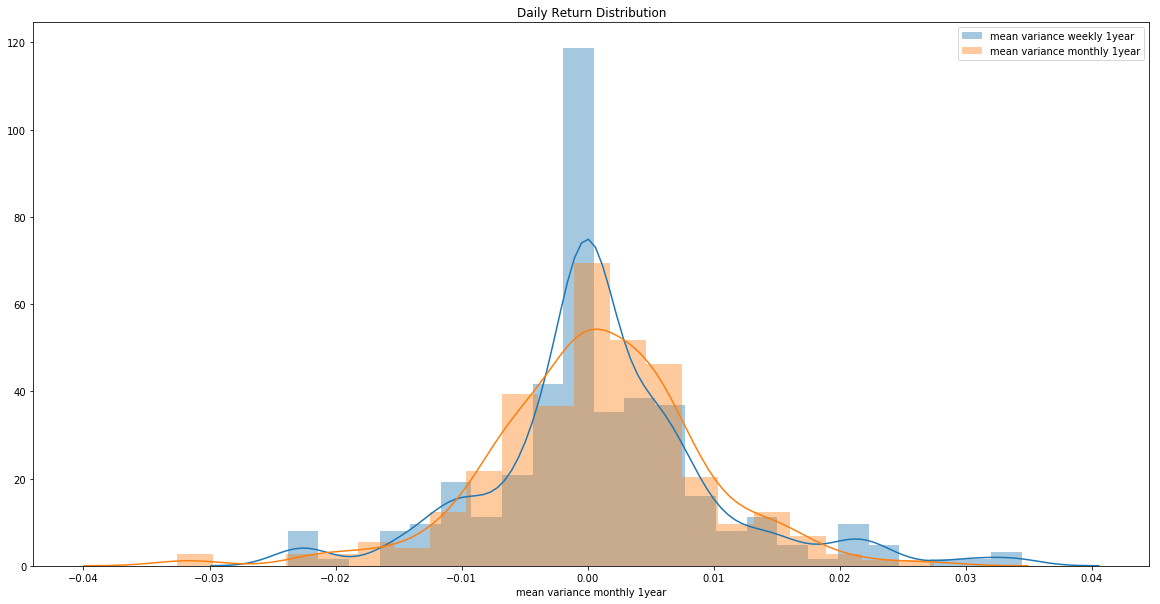

,mean variance weekly 1year,mean variance monthly 1year
Cumulated Return (%),132.335,115.779
Daily Mean Return (%),0.113151,0.0604833
Daily Min Return (%),-2.37839,-3.2546
Max 10 Days Drawdown (%),6.49412,5.54166
Volatility Daily Price,8.08734,2.79666
Volatility Daily Return (%),0.906765,0.832527
Sharpe Ratio,0.124786,0.0726502
Daily Return Skewness,0.50301,-0.347022
Daily Return Kurtosis,2.1055,1.81587
Modified VaR (%),-1.83634,-1.6929


In [42]:
#mean_variance_weight_monthly_1year = Portfolio_performance(mean_variance_weight_monthly,"mean variance monthly 1year").loc["2020-06-16":]/Portfolio_performance(mean_variance_weight_monthly,"mean variance monthly 1year").loc["2020-06-16"]*100
Features_table(pd.concat([Portfolio_performance(mean_variance_weight_weekly,"mean variance weekly 1year"),mean_variance_weight_monthly_1year],axis = 1))


<font size="4"> Step6.3.2 Minimum Variance Strategy: compare portfolio performance weekly or monthly reblance

Cumulated Daily Profit and Loss (PnL)


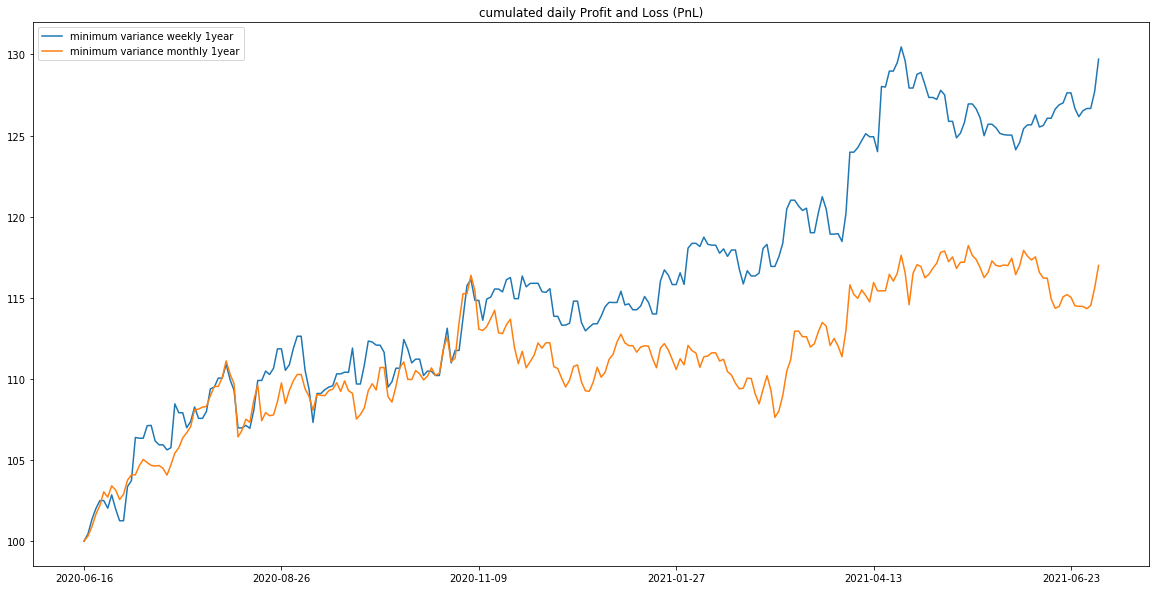

Daily Return Distribution


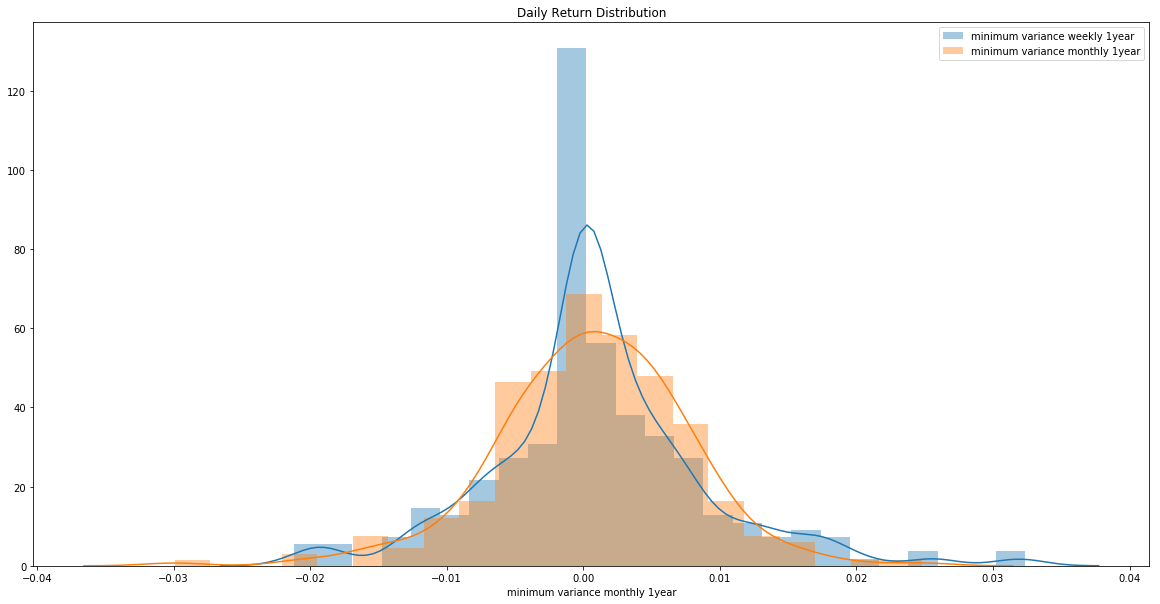

,minimum variance weekly 1year,minimum variance monthly 1year
Cumulated Return (%),129.711,116.993
Daily Mean Return (%),0.104393,0.0635344
Daily Min Return (%),-2.12039,-2.99064
Max 10 Days Drawdown (%),6.11361,5.29292
Volatility Daily Price,7.3672,3.89996
Volatility Daily Return (%),0.793024,0.700634
Sharpe Ratio,0.131639,0.0906813
Daily Return Skewness,0.516915,-0.375846
Daily Return Kurtosis,2.23708,1.76534
Modified VaR (%),-1.62149,-1.40479


In [43]:
#minimum_variance_weight_monthly_1year = Portfolio_performance(minimum_variance_weight_monthly_2year,"minimum variance monthly 1year").loc["2020-06-16":]/Portfolio_performance(minimum_variance_weight_monthly_2year,"minimum variance monthly 1year").loc["2020-06-16"]*100
Features_table(pd.concat([Portfolio_performance(minimum_variance_weight_weekly_1year,"minimum variance weekly 1year"),minimum_variance_weight_monthly_1year],axis = 1))

<font size="4"> Step6.3.3 Max Diversification Strategy: compare portfolio performance weekly or monthly reblance

Cumulated Daily Profit and Loss (PnL)


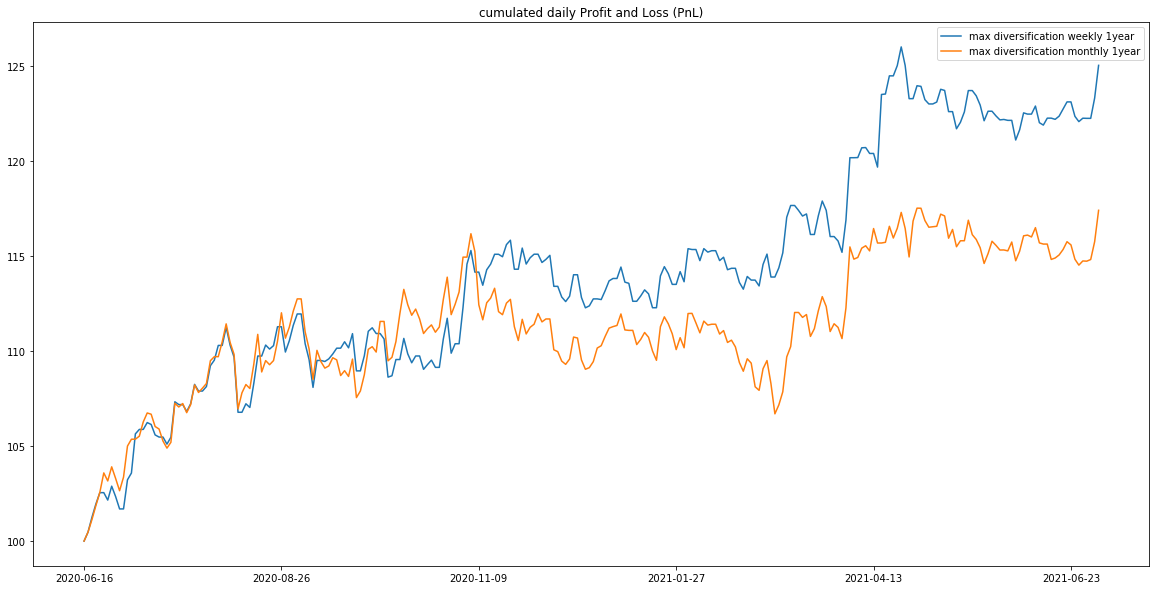

Daily Return Distribution


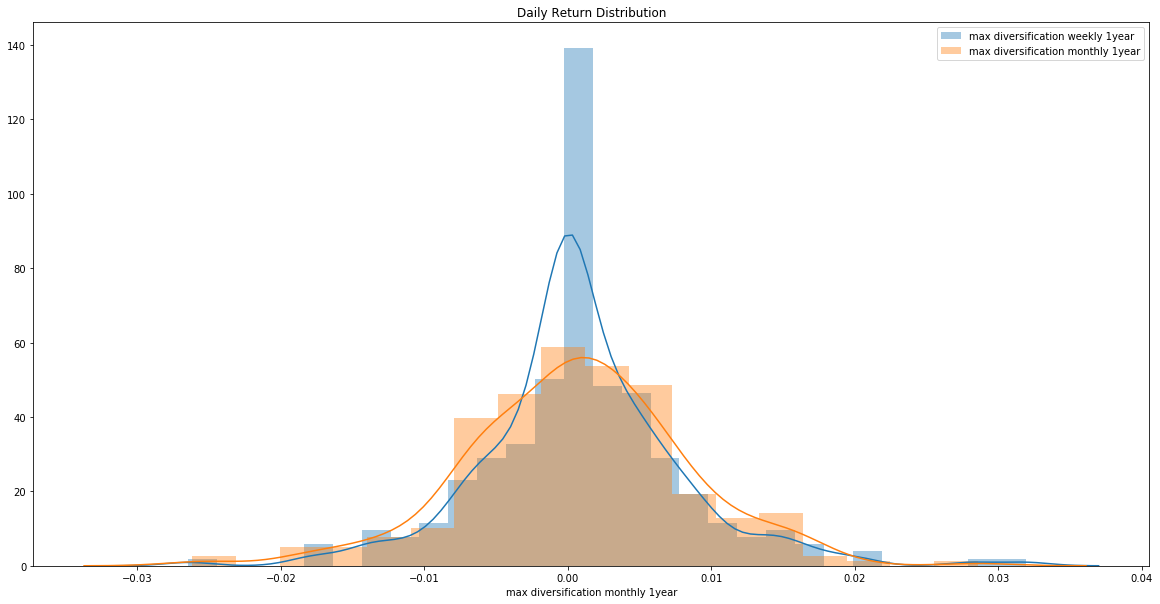

,max diversification weekly 1year,max diversification monthly 1year
Cumulated Return (%),125.04,117.41
Daily Mean Return (%),0.0894578,0.0654108
Daily Min Return (%),-2.64468,-2.61654
Max 10 Days Drawdown (%),5.35405,4.97322
Volatility Daily Price,5.97604,3.5281
Volatility Daily Return (%),0.704999,0.768081
Sharpe Ratio,0.126891,0.0851613
Daily Return Skewness,0.377787,-0.11117
Daily Return Kurtosis,2.94141,1.07637
Modified VaR (%),-1.53968,-1.41798


In [44]:
#max_diversification_weight_monthly_1year = Portfolio_performance(max_diversification_weight_monthly_2year,"max diversification monthly 1year").loc["2020-06-16":]/Portfolio_performance(max_diversification_weight_monthly_2year,"max diversification monthly 1year").loc["2020-06-16"]*100
Features_table(pd.concat([Portfolio_performance(max_diversification_weight_weekly_1year,"max diversification weekly 1year"),max_diversification_weight_monthly_1year],axis = 1))

<font size="5"> Step6.4 compare three strategies

Cumulated Daily Profit and Loss (PnL)


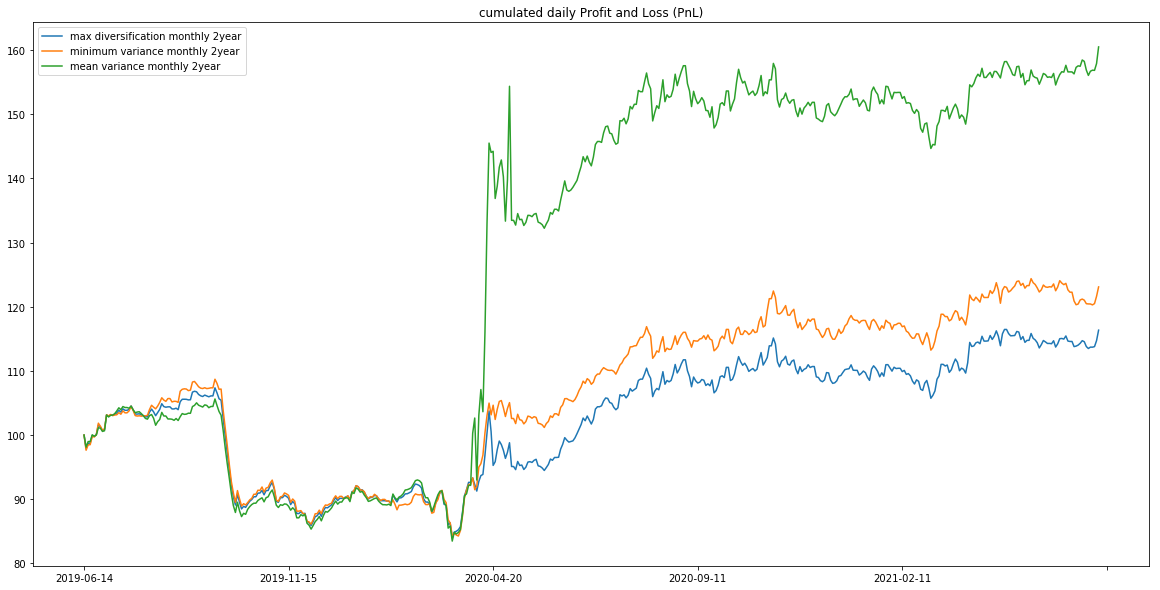

Daily Return Distribution


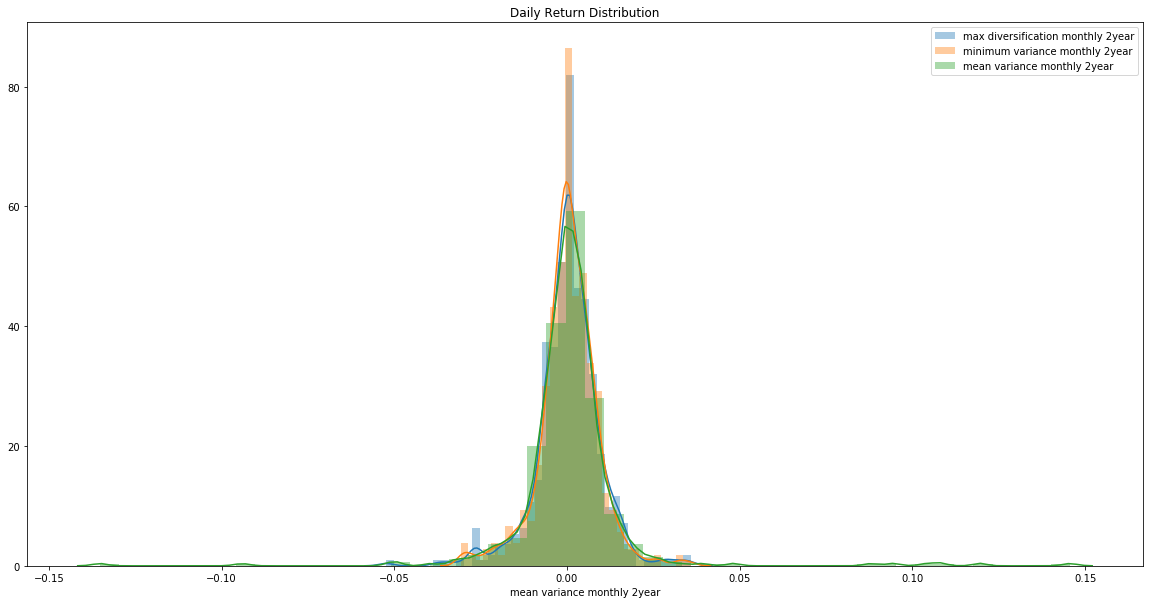

,max diversification monthly 2year,minimum variance monthly 2year,mean variance monthly 2year
Cumulated Return (%),116.353,123.093,160.5
Daily Mean Return (%),0.0348363,0.0455943,0.110107
Daily Min Return (%),-5.24093,-3.07256,-13.5342
Max 10 Days Drawdown (%),16.402,17.1715,36.6582
Volatility Daily Price,9.09346,11.8307,28.001
Volatility Daily Return (%),0.926012,0.860203,1.73012
Sharpe Ratio,0.0376196,0.0530041,0.0636414
Daily Return Skewness,-0.620255,-0.251633,1.84998
Daily Return Kurtosis,4.34727,2.79402,30.755
Modified VaR (%),-2.31552,-1.93074,12.9409


In [45]:
Features_table(pd.concat([Portfolio_performance(max_diversification_weight_monthly_2year,"max diversification monthly 2year"),Portfolio_performance(minimum_variance_weight_monthly_2year,"minimum variance monthly 2year"),Portfolio_performance(mean_variance_weight_monthly,"mean variance monthly 2year")],axis = 1))